In [1]:
import numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
#base_Edu=pd.read_parquet("D:\\2AD ENSAE\\Projet de statistique appliquée\\Dossier travail\\base_Edu.parquet")
base_Edu=pd.read_parquet("C:/Users/lisaw/Desktop/ENSAE/2AD/Projet-stat-ap/Donnees/base_Edu.parquet")
columns0=base_Edu.columns

In [3]:
print(base_Edu.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 477 entries, unique_learner_id to pct_no_objective_weeks
dtypes: Int64(72), boolean(254), datetime64[us](1), float64(150)
memory usage: 450.9 MB
None


La base de données compte donc 477 variables dont 72 de type Int, 254 de type boolean, 1 de type datetime et 150 de type float soit au total 254 variables qualitatives (**boolean**) et 221 variables quantitatives(**float + int** en excluant les identifiants) sans oublier la variable de type **datetime**.

Nous commencons par épurer la base données avant de passer à la réduction de dimension. On s'intéressera aux valeurs manquantes. 

In [4]:
missing_value=(base_Edu.isnull().sum()/len(base_Edu))
missing_value[missing_value>0]
missing_value[missing_value>0].describe()

count    404.000000
mean       0.743390
std        0.279055
min        0.047720
25%        0.666710
50%        0.842345
75%        0.918625
max        1.000000
dtype: float64

La base de données comporte donc 404 variables avec valeurs manquantes sur le total des 476 variables de la base ce qui n'est pas du tout négligeable. Voyons combien de valeurs manquantes at-on par type de variables. 

In [5]:
print(base_Edu.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(base_Edu.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(base_Edu.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(base_Edu.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

48  variables de type int ont des valeurs manquantes
103  variables de type float ont des valeurs manquantes
253  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


La seule variable de type datetime n'a donc pas de valeurs manquantes.  Analysons de plus près les proportions de valeurs manquantes des autres types

In [6]:
miss_bool=base_Edu.select_dtypes("boolean").isnull().sum()/len(base_Edu)
miss_bool[miss_bool>0].describe()

count    253.000000
mean       0.903116
std        0.072136
min        0.695085
25%        0.837765
50%        0.883305
75%        1.000000
max        1.000000
dtype: float64

Les variables de type boolean comporte pratiquement tous assez de valeurs manquantes avec un minimum de 69% et un maximum de 100% du total des observations

Les valeurs manquantes de la base ne sont pas complètement aléatoires. Elles ne sont pas pour la plupart le fruit d'une mauvaise collecte de données. La présence de valeurs manquantes dans cette base est due à diverses raisons notamment le fait que plusieurs individus de la base n'ont pas encore passé d'examen pour le permis. Plusieurs questions(variables) n'ont de sens que dans le cas où le premier examen est passé. Il y a donc une part d'information apporté par ces valeurs manquantes que nous devons inclure dans nos analyses. Pour les variables booléenne, nous pouvons régler ce prblème c'est à dire prendre en compte l'information apportée par ces valeurs manquantes en transformant les variables booléennes en variable catégorielles en considérant les valeurs manquantes comme une catégorie(True=1,False=0 et NA=2).

In [7]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=base_Edu.select_dtypes("boolean").columns
for col in colboo:
    base_Edu[col] = encode_column_with_na(base_Edu[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories


Passons maintenant aux variables quantitatives (int+float)

In [8]:
miss_quant=base_Edu.select_dtypes(include=["int","float"]).isnull().sum()/len(base_Edu)
miss_quant[miss_quant>0].describe()

count    151.000000
mean       0.475770
std        0.292138
min        0.047720
25%        0.184915
50%        0.483995
75%        0.736010
max        0.941710
dtype: float64

Pour les variables quantitatives, la distribution des valeurs manquantes est plus étendue. On enregistre 151 variables quantitatives avec valeurs manquantes. On a un minimum de 4% et un maximum de 94% de valeurs manquantes par rapport au total d'observation(nous rappelons 200000 obervations). La nature des variables et la distribution des valeurs manquantes dans ce cas ne facilite pas la capture de l'information apportée par la présence de ces valeurs manquantes. On pourrait opter pour une imputation par KNN ou par imputation itérative (MICE) mais cela risque de modifier et significativement les corrélations existant déjà entre les variables introduisant ainsi un important biais et au vue de la taille de l'echantillon, cela demanderait un temps d'excution énorme. On choisit ici donc de procéder à une imputation par la médiane après suppression des variables avant un taux élevé de valeurs manquantes pour minimiser le biais. Cela permettra de ne pas trop distordre les distributions existentes.

In [9]:
miss_quant[miss_quant<=0.20].describe()

count    118.000000
mean       0.054362
std        0.074368
min        0.000000
25%        0.000000
50%        0.000000
75%        0.106310
max        0.194530
dtype: float64

Nous choisissons le seuil de 20% de valeurs manquantes. Ce seuil nous parait raisonnable puisqu'il est relativement faible et n'entraine pas la suppression d'un grand nombre de variables quantitatives (118 sont conservées sur un total de 151)

In [10]:
#suppression des variables avec plus de 20% de valeurs manquantes
base_Edu=base_Edu.drop(columns=miss_quant[miss_quant>0.20].index)
#Imputation par la médiane
col=base_Edu.select_dtypes(exclude='category').columns
base_Edu[col] = base_Edu[col].fillna(base_Edu[col].median())

In [11]:
base_Edu.isnull().any().sum()

0

Plus aucune valeur manquante. La base de données enfin prête, on peut passer aux opérations de réduction de dimension

## Auto-Encoder

Nous commencons d'abord par exclure les identifiants ainsi que la variable de type datetime de la base qui ne présentent aucun intérêt pour notre auto encoder

Pour des raisons liées à la puissance de calcul, nous nous servirons de 30000 observations pour notre Auto-Encoder. 

In [12]:
base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1).head(30000)

Le calibrage des hyperparamètres tels que le nombre de couche, les fonctions d'activations, le type de normalisation est détaillé dans l'annexe du fichier AutoEncoder. Ont été retenus les hyperparamètre suivant : 
* Type de normalisation : MinMax
* Nombre de couche : Une couche caché en encdeur et au niveau du décodeur
* Fonctions d'activation : **Linear** dans les couches de l'encodeur et **sigmoid** en décodeur 

Nous nous concentrerons donc maintenant sure le choix de la dimension latente. 

### Choix du Nombre Optimal de Dimensions Latentes pour un Autoencodeur : Une Analyse Basée sur l’Information Mutuelle
Dans le cadre de la réduction de dimension à l’aide d’un autoencodeur, l’un des défis majeurs consiste à choisir un nombre optimal de dimensions latentes permettant d’atteindre un compromis entre compacité de la représentation et préservation de l’information essentielle. Pour guider ce choix, nous nous appuyons sur une mesure clé : l’information mutuelle.

L’information mutuelle est une mesure issue de la théorie de l’information qui quantifie la dépendance entre deux ensembles de variables. Plus précisément, dans notre contexte, elle permet d’évaluer dans quelle mesure les variables latentes conservent l’information contenue dans les variables d’origine. Formellement, l’information mutuelle entre deux variables aléatoires $(X)$ et $(Z)$ est donnée par :


$I(X,Z) = \sum_{x \in X} \sum_{z \in Z} P(x, z) \log \frac{P(x, z)}{P(x) P(z)}$

où $(P(x, z))$ est la distribution conjointe de $(X)$ et $(Z)$, et $(P(x))$, $(P(z))$ sont leurs distributions marginales respectives.

Dans le contexte d’un autoencodeur, cette mesure nous permet de quantifier la capacité des dimensions latentes à encoder efficacement l’information contenue dans les données initiales. Une information mutuelle élevée signifie que la représentation latente conserve beaucoup d’information sur les données originales, tandis qu’une information mutuelle faible suggère une perte d’information plus importante.


657/657 [==============================] - 2s 3ms/step


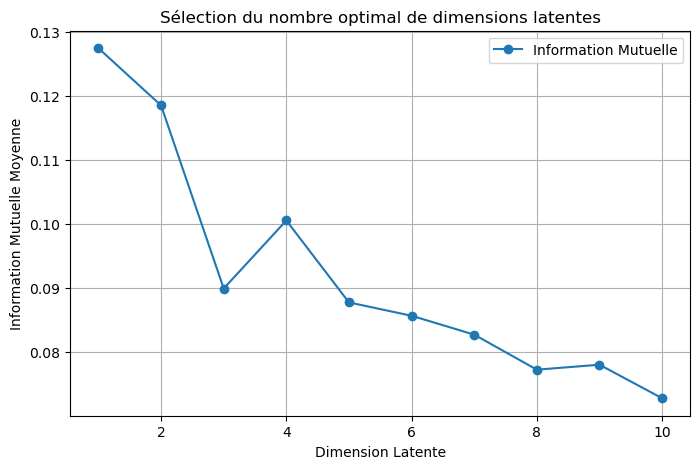

In [14]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

final_data = np.hstack([encoded_cats, scaled_nums])
final_columns = list(encoded_cat_columns) + list(numerical_cols)

x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)
input_dim = x_train.shape[1]
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

# === 3. Tester différentes dimensions latentes et calculer l'information mutuelle ===
mutual_info_scores = []
latent_dims = range(1, 11)

for encoding_dim in latent_dims:
    input_img = Input(shape=(input_dim,))
    Hidden1 = Dense(350, activation='linear', kernel_initializer=initializer)(input_img)
    encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)
    Hidden_output1 = Dense(350, activation='sigmoid', kernel_initializer=initializer)(encoded)
    decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test), verbose=0)
    
    encoder_model = Model(input_img, encoded)
    encoded_imgs = encoder_model.predict(x_train)
    
    mi_scores = np.array([
        np.mean([mutual_info_regression(x_train[:, j].reshape(-1, 1), encoded_imgs[:, i]) 
                 for j in range(x_train.shape[1])])
        for i in range(encoding_dim)
    ])
    
    mutual_info_scores.append(np.mean(mi_scores))

# === 4. Tracer la courbe de l'information mutuelle ===
plt.figure(figsize=(8, 5))
plt.plot(latent_dims, mutual_info_scores, marker='o', linestyle='-', label="Information Mutuelle")
plt.xlabel("Dimension Latente")
plt.ylabel("Information Mutuelle Moyenne")
plt.title("Sélection du nombre optimal de dimensions latentes")
plt.legend()
plt.grid()
plt.show()


L’analyse de la courbe obtenue montre une tendance générale décroissante de l’information mutuelle moyenne lorsque le nombre de dimensions latentes augmente. Cela est attendu, car en réduisant la dimensionnalité, nous éliminons progressivement certaines redondances mais aussi, potentiellement, des informations pertinentes. Lorsque la dimension est faible, l'essentielle de l'inforamtion capté se comprime donc au sein de ces variables latentes. Ces variables se retrouvent donc finalement riche en imformation pertinente essentielle à l'explication des variables d'origine. Et plus le nombre de variables latentes augmente, plus l'information capté est plus dispersé au sein de ces variables, et est moins pertinente. C'est ce qui l'explique l'evolution globablement décroissante observée. 

* Entre 1 et 3: On observe une baisse brutale de l'information mutuelle moyenne. En effet, lorsqu'on augmente la dimension de l'espace latent, il y a une part supplémentaire d'information captée, cette baisse suggère que cette part d'information nouvellement captée ou apportée par l'introduction de cette nouvelle variable est plus faible que la moyenne apportée juste avec les axes précédents. Ou autrement, l'information captée est de moins en moins pertinente. 
* Entre 3 et 4  : On observe une remontée de l'information mutuelle moyenne : Il y a donc une part d'information très pertinente en tout cas supérieur à la moyenne déjà présnete que l'introduction d'une quatrième dimension permet de capter. 
* Entre 4 et 5 :  On observe à nouveau la décroissance brutale de l'information mutuelle moyenne ce qui signifie que l'introduction d'une cinquième dimension permet de capter une information beaucoup moins pertinente. 
* Après 5 : On observe maintenant une tendance presque linéaire et beaucoup plus progressive. Cela signifie qu'après l'information capté est presque qu'équivalente à la moyenne déjà captée. Le fait que cette tendence soit progressive c'est à dire ne varie plus significativement laisse supposé qu'après 5 dimensions, cette quantité minimale d'information que l'introduction d'une nouvelle dimension permet de capter qui l'est. 

En effet, on devrait s'attendre à observer la tendence obtenue après 5 dimension à un moment donné puisqu'il y aura nécessairement une dimension à partir de laquelle l'information capté ne sera plus très pertinente. Et à chaque fois l'introduction d'une nouvelle dimension ne ferait que capter une quantité presqu'équivalente mais moins pertinente. Ce qui conduirait à une tendence similaire à celle observée après 5. Le fait qu'on a plus de chute brutale ou de légère remontées de l'information indique que c'est ce seuil qui est atteint. 

Nous pouvons donc nous limiter à 5 dimension puisque cette valeur nous permet de capter les informations que nous pouvons juger de plus pertinentes. 


Ce choix garantit un équilibre optimal entre compression et préservation d’information, permettant ainsi d’assurer une représentation efficace et compacte des données tout en évitant des dimensions inutiles.

L’étape suivante consiste à valider ce choix à l’aide de l’erreur de reconstruction, pour s’assurer que l’information capturée par ces 5 dimensions latentes est suffisante pour une bonne qualité de reconstruction des données originales.

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0930 - val_loss: 0.0409
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0420 - val_loss: 0.0393
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0408 - val_loss: 0.0383
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0393 - val_loss: 0.0364
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0378 - val_loss: 0.0357
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0372 - val_loss: 0.0352
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0367 - val_loss: 0.0347
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0363 - val_loss: 0.0345
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0360 - val_loss: 0.0343
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0358 - val_loss: 0.0342
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0356 - val_loss: 0.0340
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0355 - v

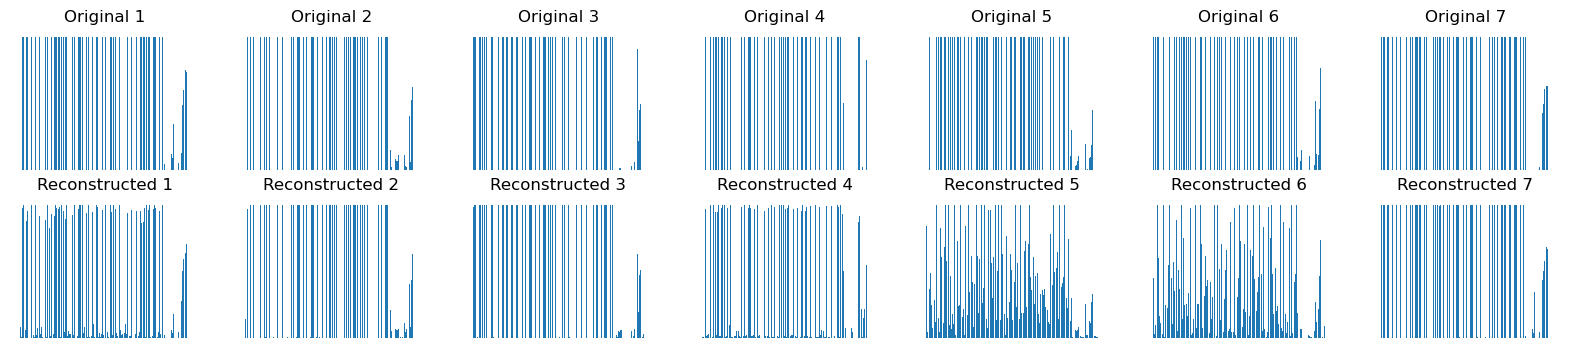

Erreur moyenne de reconstruction : 0.0320


In [17]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
#input_dim = x_train.shape[1]

# === 2. Définition de l'autoencodeur ===
input_dim = x_train.shape[1]  # Assurez-vous que x_train est bien défini
encoding_dim = 5

# Initialisation déterministe des poids
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

input_img = Input(shape=(input_dim,))
# Encodeur
Hidden1 = Dense(350, activation='relu', kernel_initializer=initializer)(input_img)
#Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
#Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

# Décodeur
Hidden_output1 = Dense(350, activation='sigmoid', kernel_initializer=initializer)(encoded)
#Hidden_output2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden_output1)
#Hidden_output3 = Dense(256, activation='relu', kernel_initializer=initializer)(Hidden_output2)
decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche

# Modèle autoencodeur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=1)

# Modèle de l'encodeur seul
encoder = Model(input_img, encoded)

# Représentations encodées (latent space)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# === 4. Visualisation des performances ===
n = 7
plt.figure(figsize=(20, 4))

for i in range(n):
    # Données originales
    ax = plt.subplot(2, n, i + 1)
    plt.bar(range(len(x_test[i])), x_test[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

# Analyse des erreurs de reconstruction
reconstruction_error = np.mean((x_test - decoded_imgs) ** 2, axis=1)
print(f"Erreur moyenne de reconstruction : {np.mean(reconstruction_error):.4f}")


In [13]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
#input_dim = x_train.shape[1]

# === 2. Définition de l'autoencodeur ===
input_dim = x_train.shape[1]  # Assurez-vous que x_train est bien défini
encoding_dims = np.arange(1,11)

# Initialisation déterministe des poids
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)
reconstruction_error=[]
for encoding_dim in encoding_dims:
    input_img = Input(shape=(input_dim,))
# Encodeur
    Hidden1 = Dense(350, activation='relu', kernel_initializer=initializer)(input_img)
#Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
#Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
    encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

# Décodeur
    Hidden_output1 = Dense(350, activation='sigmoid', kernel_initializer=initializer)(encoded)
#Hidden_output2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden_output1)
#Hidden_output3 = Dense(256, activation='relu', kernel_initializer=initializer)(Hidden_output2)
    decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche

# Modèle autoencodeur
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
    history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=1)

# Modèle de l'encodeur seul
    encoder = Model(input_img, encoded)

# Représentations encodées (latent space)
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = autoencoder.predict(x_test)

# Analyse des erreurs de reconstruction
    reconstruction_error.append(np.mean((x_test - decoded_imgs) ** 2, axis=1))

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0943 - val_loss: 0.0411
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0424 - val_loss: 0.0400
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0416 - val_loss: 0.0399
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0413 - val_loss: 0.0395
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0410 - val_loss: 0.0393
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0408 - val_loss: 0.0391
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0407 - val_loss: 0.0389
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0406 - val_loss: 0.0388
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0405 - val_loss: 0.0387
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0404 - val_loss: 0.0387
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0404 - val_loss: 0.0387
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0

KeyboardInterrupt: 

In [26]:
for i in np.arange(1,11):
    print(np.mean(reconstruction_error[i]))


IndexError: list index out of range

In [27]:
reconstruction_error

[array([0.03745824, 0.00272437, 0.00147813, ..., 0.03076454, 0.1347392 ,
        0.0019649 ])]

Nous obtenons une erreur de reconstruction égale à 0.0328. Ce qui indique que l'autoencodeur parvient à reconstruire les données d'origine avec une précision raisonnable. Nous maintenons donc 5 comme dimension de l'espace latent. 

Aussi Le graphique précédent fait une comparaison entre les 7 premières données originales et leurs versions reconstruites (pour une dimension k=5 de l'espace latent). Et la ressemblence obervée est très forte. Cela témoigne du fait que la valeur k=5 de l'hyperparamètre suffit à capturer efficacement la structure initiale de nos données. 

Le point de départ le plus simple pour une interprétation globale avec SHAP consiste à examiner la valeur SHAP absolue moyenne de chaque caractéristique sur l'ensemble des données. Cela permet de quantifier, en moyenne, l'ampleur (positive ou négative) de la contribution de chaque caractéristique aux prix des logements prévus. Les caractéristiques ayant des valeurs SHAP absolues moyennes plus élevées sont plus influentes.

In [16]:
import tensorflow as tf

# Supposons que ton autoencoder soit défini sous le nom 'autoencoder'
autoencoder.save("autoencoder.h5")  # Sauvegarde au format HDF5

In [14]:
import tensorflow as tf

# Charger le modèle
autoencoder = tf.keras.models.load_model("autoencoder.h5")

Nous allons maintenant passer à l'interprétation des nos 5 variables latentes. Mais pour le faire il nous faut savoir quelles variables d'origines ont plus d'influence sur chacun des variables latentes. Pour capturer cette information, nous utiliserons la méthode GradiantExplainer de la bibliothèque shap qui nous donnera une approximation de l'effet d'une pertubation élémentaire de chacune des variables d'origine suer chacune des variables latentes. 

In [45]:
import shap

# === 2. SHAP pour l'analyse des variables d'origine ===
# Adaptation du modèle pour SHAP ===
# Le modèle doit inclure les couches d'entrée jusqu'à l'encodage
#explainer = shap.DeepExplainer(encoder, x_train)  # Sous-échantillon de référence
explainer = shap.GradientExplainer(encoder, x_train)
# === 2. Récupérer les valeurs SHAP pour les données de test ===
shap_values = explainer.shap_values(x_test)  # Analyser un sous-échantillon de test

d:\Anaconda\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Le point de départ le plus simple pour une interprétation globale avec SHAP consiste à examiner la valeur SHAP absolue moyenne de chaque caractéristique sur l'ensemble des données. Cela permet de quantifier, en moyenne, l'ampleur (positive ou négative) de la contribution de chaque caractéristique (variables d'origines) aux variables latentes. Les caractéristiques ayant des valeurs SHAP absolues moyennes plus élevées sont plus influentes.

In [46]:
import pandas as pd

# Pour chaque dimension latente
for i in range(5):  # 10 dimensions latentes
    shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
    # Créer un DataFrame des valeurs SHAP pour les variables d'origine
    shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
    # Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
    mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    print(f"Les variables les plus influentes pour la {i+1}-ème dimension latente:")
    print(mean_shap_values.head(20))  # Afficher les 5 variables les plus influentes pour la dimension latente i+1


Les variables les plus influentes pour la 1-ème dimension latente:
is_first_exam_success_1                              4.034718
is_first_exam_success_2                              2.978691
pct_no_objective_weeks                               2.667401
pct_study_objective_not_reached                      2.492003
choice_01_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1     2.290542
choice_00_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1     2.270693
prendre_quitter_vehicule_number_of_activities        1.852288
has_passed_theory_exam_1                             1.827179
autres_usagers_number_of_activities                  1.775425
is_correct_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1    1.733057
choice_03_f581c15d-eca9-4b40-88e5-37887323a4a9_0     1.719560
notions_diverses_number_of_activities                1.697741
is_correct_f581c15d-eca9-4b40-88e5-37887323a4a9_0    1.675951
choice_00_f581c15d-eca9-4b40-88e5-37887323a4a9_1     1.618704
securite_number_of_activities                        1.600148
is_

La sortie précédente donne pour chacune des variables de la dimension latente les variables d'origine les plus influentes c'est à dire celle ayant les valeurs absolues moyenne shap les plusz élévé. Mais cette sortie serait plus intéressante sous forme de graphique.

Pour chacune des variables latentes, nous procèderons aussi à la représentation des **Parcelles d'essaims d'abeilles** encore appelées **Beeswarm**. Les graphiques Beeswarm sont une représentation plus complexe et plus riche en informations des valeurs SHAP qui révèle non seulement l'importance relative des caractéristiques, mais également leurs relations réelles avec le résultat prévu. Dans ce cas de l'autoencoder, elle nous permet de connaitre quel aspect de la variable d'origine est capté par la variable latente. Un shap négatif signifie ici que la variable d’entrée agit dans le sens opposé à ce que la dimension latente représente.

La représentation des **Beeswarm** se fera avec les variables les plus influences permettant d'avoir un cumul de valeur absolue moyenne shap de 25% du total. 

Fixer le seuil à 25% permet d’adopter une approche équilibrée et justifiable pour sélectionner les variables les plus influentes. Si l’on prend trop peu de variables (ex. 10-20%), on risque d’exclure des informations essentielles et de sous-estimer certains effets. À l’inverse, inclure trop de variables (ex. 30-50%) augmente la complexité sans forcément apporter une meilleure compréhension. En se basant sur la courbe cumulative des valeurs SHAP, 25% est souvent un point où l’on capture une grande partie de l’influence totale, ce qui garantit une analyse pertinente tout en restant concise. Ce choix permet ainsi d’expliquer efficacement le comportement du modèle sans s’encombrer de bruit inutile.

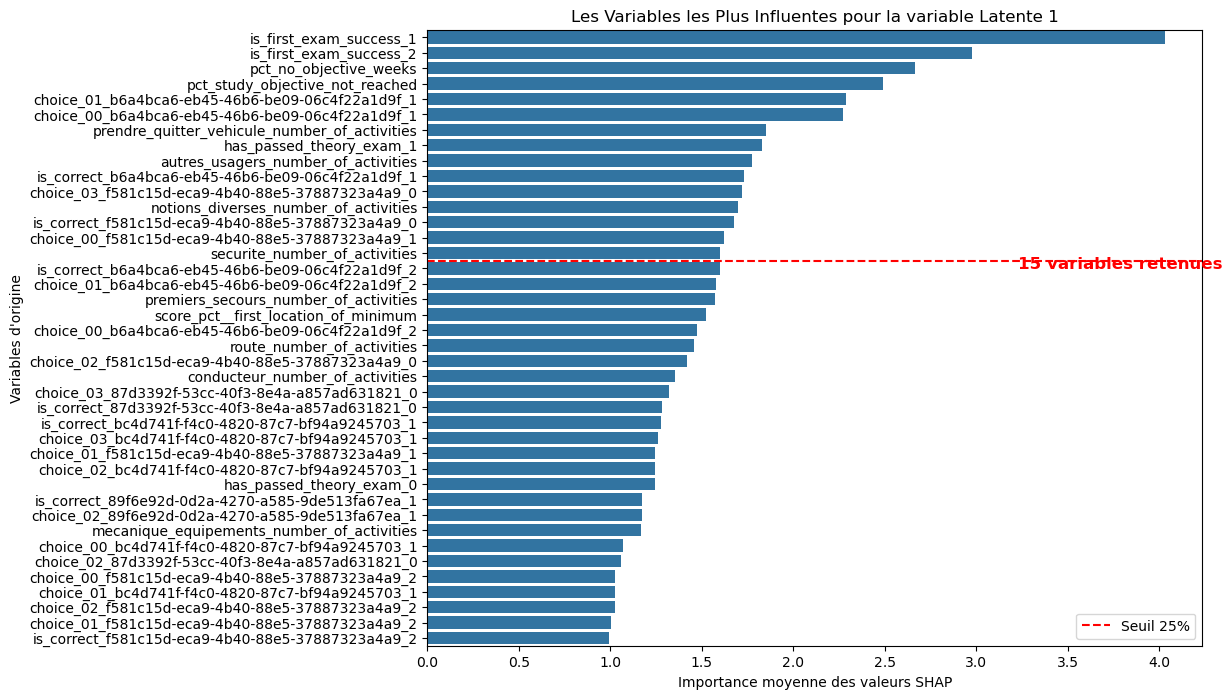

Nombre de variables nécessaires pour couvrir 25% de l'importance totale : 15


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choix de la dimension latente
i = 0  # Modifier si besoin

# Extraction des SHAP values pour cette dimension latente
shap_val = shap_values[:, :, i]  

# Création d'un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  

# Importance moyenne absolue des SHAP values (classement décroissant)
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  

# Calcul de l'importance cumulée
cumulative_importance = mean_shap_values.cumsum() / mean_shap_values.sum()

# Trouver le nombre de variables nécessaires pour atteindre 30% de l'importance cumulée
num_selected_features = (cumulative_importance <= 0.20).sum()

# Affichage du barplot avec trait horizontal pour 30%
plt.figure(figsize=(10, 8))
sns.barplot(x=mean_shap_values.head(40).values, y=mean_shap_values.head(40).index, orient='h')

# Ajout d'un trait horizontal au niveau du seuil des 30%
plt.axhline(y=num_selected_features - 0.5, color='red', linestyle='--', label="Seuil 25%")

# Annotation du nombre de variables retenues
plt.text(mean_shap_values.max() * 0.8, num_selected_features, 
         f"{num_selected_features} variables retenues", 
         color="red", fontsize=12, fontweight="bold")

# Titres et labels
plt.title(f"Les Variables les Plus Influentes pour la variable Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.legend()
plt.show()

# Affichage du nombre de variables retenues
print(f"Nombre de variables nécessaires pour couvrir 25% de l'importance totale : {num_selected_features}")


Pour cette première variable latente, nous nous servirons donc des 15 variables d'origines comme indiquée sur la représentation précédente pour l'explication de la variable latente à l'aide du **Beeswarm**. 

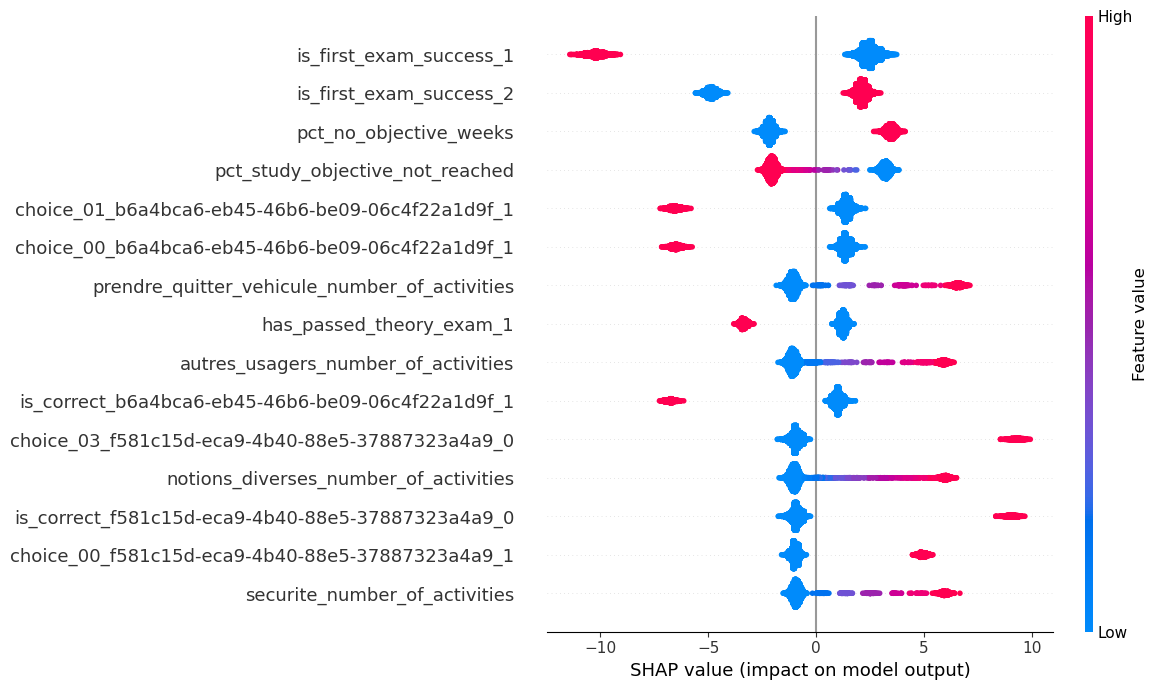

In [69]:
# Choisir la dimension latente à analyser (ex : la 5ème)
latent_dim_index = 0  

# Extraire les valeurs SHAP pour cette dimension latente
shap_val = shap_values[:, :, latent_dim_index]  # Shape : (9000, 724)

# Affichage du SHAP summary plot

shap.summary_plot(shap_val, x_test, feature_names=final_columns, max_display=15,plot_size=(12, 7))

Nous recensons ici des : 
* Variables liées aux **activités de formation**  

  - `prendre_quitter_vehicule_number_of_activities`  
  - `autres_usagers_number_of_activities`  
  - `notions_diverses_number_of_activities`  
  - `securite_number_of_activities`  

**Effet sur le facteur (SHAP positif quand les valeurs sont élevées) :**  
✔ Plus le candidat réalise d’activités dans ces catégories, plus ce facteur augmente.  
✔ Cela traduit **un fort engagement et un investissement personnel**.  
L’effort fourni dans la formation impacte positivement ce facteur.

* Variables liées à **la réussite aux examens** 🎯  

  - `is_first_exam_success_1` (**Réussite au premier essai**)  
  - `is_first_exam_success_2` (**NA, absence d’info**)  
  - `has_passed_theory_exam_1` (**Réussite à l’examen théorique**)  

**Effet sur le facteur :**  
✔ Quand `is_first_exam_success_1 = 0` (**échec au premier essai**), SHAP est **positif**, ce qui signifie que **rater le premier essai contribue positivement à ce facteur.**  

Ce facteur ne mesure pas directement la réussite, mais plutôt **l’apprentissage à travers l’échec et l’investissement dans la formation.**


* Variables liées aux **choix et correction des réponses  

  - `choice_01_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1` (Choix effectué pour une question)  
  - `choice_00_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1` (Autre choix pour la même question)  
  - `is_correct_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1` (Réponse correcte ou non)  
  - `is_correct_f581c15d-eca9-4b40-88e5-37887323a4a9_0` (Autre question)  

**Effet sur le facteur :**  
✔ Les choix influencent le facteur, mais **répondre juste ou faux a un effet moindre**.  
✔ Cela montre que ce facteur **ne mesure pas uniquement la performance, mais aussi la prise de décision et l’investissement dans l’examen**.  

**Répondre aux questions (même incorrectement) est un indicateur d’engagement actif.**


* Variables d’**objectifs d’apprentissage**   

  - `pct_no_objective_weeks` (**Pourcentage de semaines sans objectif**)  
  - `pct_study_objective_not_reached` (**Pourcentage d’objectifs non atteints**)  

**Effet sur le facteur :**  
✔ **Quand ces variables augmentent, SHAP est négatif**, ce qui signifie que **le manque d’objectifs diminue ce facteur**.  

 **Ne pas structurer son apprentissage nuit au processus d’engagement.**


**Synthèse : Ce que représente ce facteur**  

✔ **Ce facteur ne reflète pas uniquement la réussite finale**, mais **plutôt l’investissement et le processus d’apprentissage**.  
✔ **Échouer au premier essai** et **réaliser beaucoup d’activités** renforcent ce facteur.  
✔ **Répondre aux questions (même incorrectement) contribue aussi à l’engagement.**  
✔ **Un manque d’objectifs affaiblit ce facteur.**  

Pour cette variable, nous proposons donc le nom : **"Investissement et apprentissage par l’effort"**  
(ou "Persévérance et engagement dans la formation")_


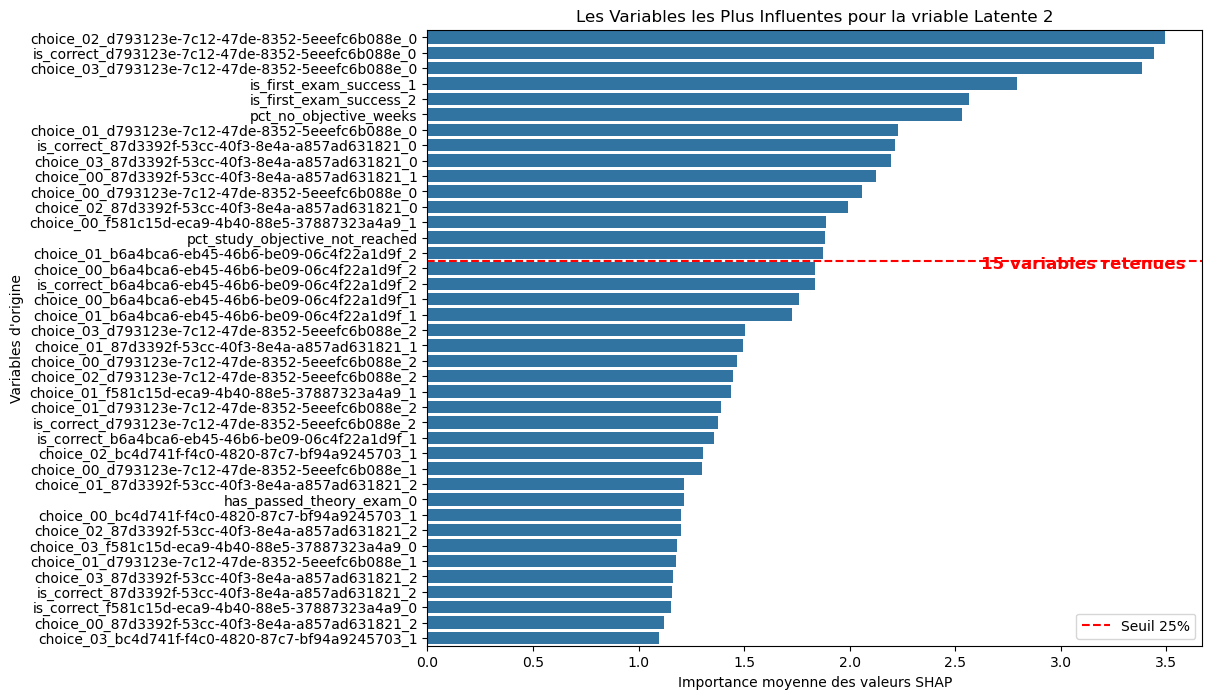

Nombre de variables nécessaires pour couvrir 25% de l'importance totale : 15


In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choix de la dimension latente
i = 1  # Modifier si besoin

# Extraction des SHAP values pour cette dimension latente
shap_val = shap_values[:, :, i]  

# Création d'un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  

# Importance moyenne absolue des SHAP values (classement décroissant)
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  

# Calcul de l'importance cumulée
cumulative_importance = mean_shap_values.cumsum() / mean_shap_values.sum()

# Trouver le nombre de variables nécessaires pour atteindre 30% de l'importance cumulée
num_selected_features = (cumulative_importance <= 0.25).sum()

# Affichage du barplot avec trait horizontal pour 30%
plt.figure(figsize=(10, 8))
sns.barplot(x=mean_shap_values.head(40).values, y=mean_shap_values.head(40).index, orient='h')

# Ajout d'un trait horizontal au niveau du seuil des 30%
plt.axhline(y=num_selected_features - 0.5, color='red', linestyle='--', label="Seuil 25%")

# Annotation du nombre de variables retenues
plt.text(mean_shap_values.max() * 0.75, num_selected_features, 
         f"{num_selected_features} variables retenues", 
         color="red", fontsize=12, fontweight="bold")

# Titres et labels
plt.title(f"Les Variables les Plus Influentes pour la vriable Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.legend()
plt.show()

# Affichage du nombre de variables retenues
print(f"Nombre de variables nécessaires pour couvrir 25% de l'importance totale : {num_selected_features}")


Pour cette deuxième variable latente, nous nous servirons donc aussi des 15 variables d'origines comme indiquée sur la représentation précédente pour l'explication de la variable latente à l'aide du **Beeswarm**. 

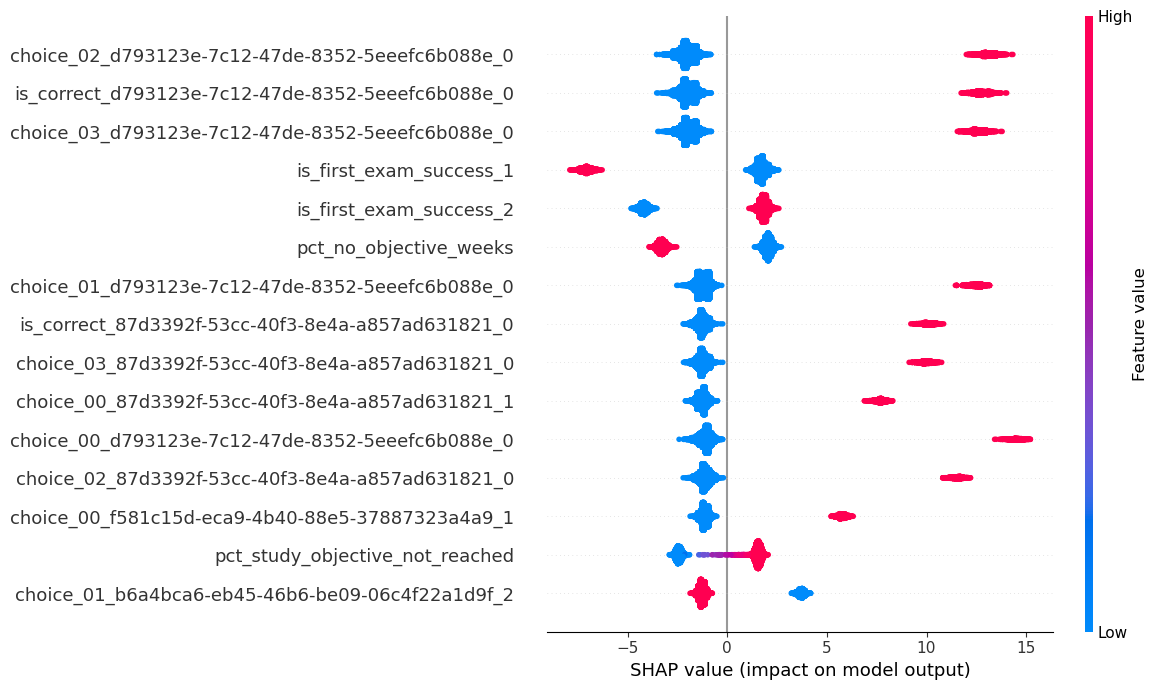

In [70]:
# Choisir la dimension latente à analyser (ex : la 5ème)
latent_dim_index = 1 

# Extraire les valeurs SHAP pour cette dimension latente
shap_val = shap_values[:, :, latent_dim_index]  # Shape : (9000, 724)

# Affichage du SHAP summary plot
shap.summary_plot(shap_val, x_test, feature_names=final_columns, max_display=15,plot_size=(12, 7))

Nous recensons ici des :  

* Variables liées aux **choix et correction des réponses**  

  - `choice_02_d793123e-7c12-47de-8352-5eeefc6b088e_0` (Modalité 02 d'une question)  
  - `choice_03_d793123e-7c12-47de-8352-5eeefc6b088e_0` (Modalité 03 d'une question)  
  - `choice_01_d793123e-7c12-47de-8352-5eeefc6b088e_0` (Modalité 01 d'une question)  
  - `choice_00_87d3392f-53cc-40f3-8e4a-a857ad631821_1` (Modalité 00 d'une autre question)  
  - `choice_02_87d3392f-53cc-40f3-8e4a-a857ad631821_0` (Modalité 02 d'une autre question)  
  - `choice_03_87d3392f-53cc-40f3-8e4a-a857ad631821_0` (Modalité 03 d'une autre question)  
  - `is_correct_d793123e-7c12-47de-8352-5eeefc6b088e_0` (**Réponse incorrecte**)  
  - `is_correct_87d3392f-53cc-40f3-8e4a-a857ad631821_0` (**Réponse incorrecte pour une autre question**)  

**Effet sur le facteur** :  
✔ **Les choix effectués influencent fortement ce facteur.**  
✔ **Répondre incorrectement impacte ce facteur de manière significative.**  
✔ **Cela pourrait refléter une mesure de la prise de décision ou de la difficulté perçue dans l'examen.**  

* Variables liées à **la réussite aux examens**  

  - `is_first_exam_success_1` (**Réussite au premier essai**)  
  - `is_first_exam_success_2` (**NA, absence d’info**)    
✔ **Quand `is_first_exam_success_1 = 0` (échec au premier essai), SHAP est positif**, ce qui signifie que **rater le premier essai contribue positivement à ce facteur.**  
✔ **Ce facteur semble être lié à l'expérience de l'examen plutôt qu'à la réussite pure.**  

* Variables d’**objectifs d’apprentissage**  

  - `pct_no_objective_weeks` (**Pourcentage de semaines sans objectif**)  
  - `pct_study_objective_not_reached` (**Pourcentage d’objectifs non atteints**)   
✔ **Quand ces variables augmentent, SHAP est négatif**, ce qui signifie que **le manque d’objectifs diminue ce facteur**.  
✔ **Ce facteur semble être influencé par la structuration de l’apprentissage et la planification.**  

**Synthèse : Ce que représente ce facteur**  

✔ **Ce facteur ne reflète pas directement la réussite, mais plutôt l’engagement dans l’examen et la manière dont le candidat aborde les questions.**  
✔ **L’échec au premier essai renforce ce facteur, indiquant qu’il mesure peut-être l’expérience accumulée.**  
✔ **Les choix et erreurs influencent fortement ce facteur, ce qui pourrait refléter une forme de persévérance face aux difficultés.**  
✔ **Un manque d’objectifs d’apprentissage tend à affaiblir ce facteur, suggérant qu’une préparation rigoureuse est un élément clé.**  

Proposition de nom pour ce facteur :  
➡ **"Expérience au test théorique et stratégie d’apprentissage"**  
➡ **(ou "Approche et adaptation à l’examen")**


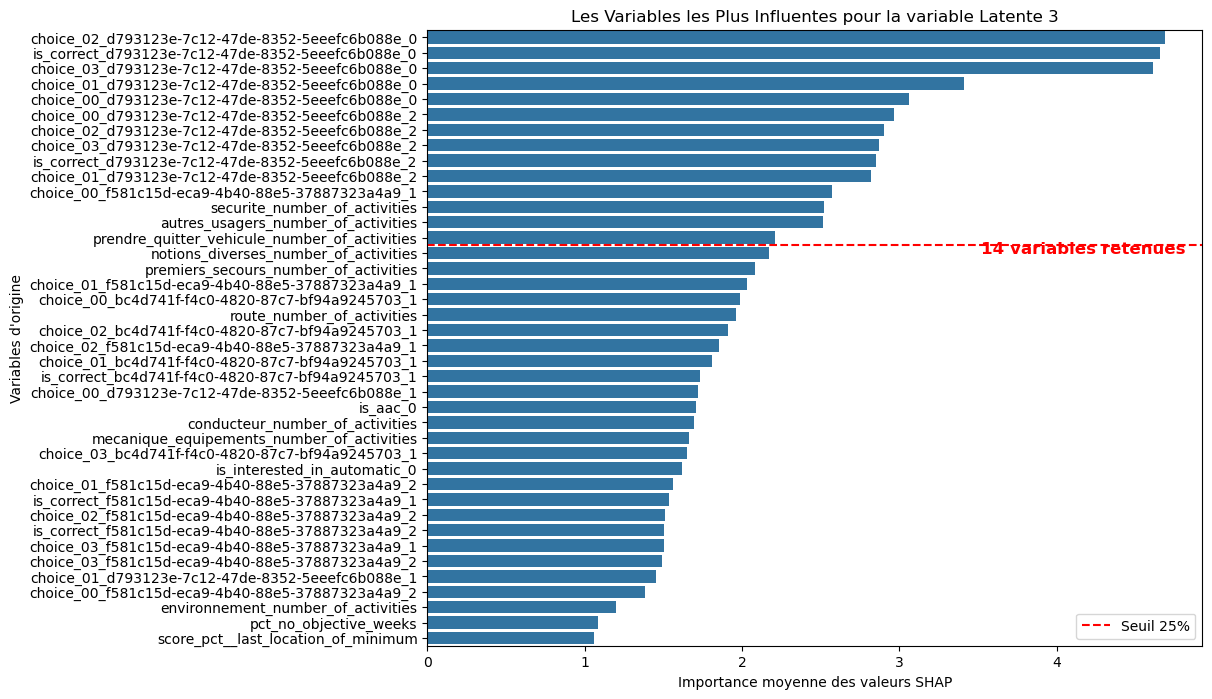

Nombre de variables nécessaires pour couvrir 25% de l'importance totale : 14


In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choix de la dimension latente
i = 2  # Modifier si besoin

# Extraction des SHAP values pour cette dimension latente
shap_val = shap_values[:, :, i]  

# Création d'un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  

# Importance moyenne absolue des SHAP values (classement décroissant)
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  

# Calcul de l'importance cumulée
cumulative_importance = mean_shap_values.cumsum() / mean_shap_values.sum()

# Trouver le nombre de variables nécessaires pour atteindre 30% de l'importance cumulée
num_selected_features = (cumulative_importance <= 0.25).sum()

# Affichage du barplot avec trait horizontal pour 30%
plt.figure(figsize=(10, 8))
sns.barplot(x=mean_shap_values.head(40).values, y=mean_shap_values.head(40).index, orient='h')

# Ajout d'un trait horizontal au niveau du seuil des 30%
plt.axhline(y=num_selected_features - 0.5, color='red', linestyle='--', label="Seuil 25%")

# Annotation du nombre de variables retenues
plt.text(mean_shap_values.max() * 0.75, num_selected_features, 
         f"{num_selected_features} variables retenues", 
         color="red", fontsize=12, fontweight="bold")

# Titres et labels
plt.title(f"Les Variables les Plus Influentes pour la variable Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.legend()
plt.show()

# Affichage du nombre de variables retenues
print(f"Nombre de variables nécessaires pour couvrir 25% de l'importance totale : {num_selected_features}")


Pour cette deuxième variable latente, nous nous servirons donc aussi des 14 variables d'origines comme indiquée sur la représentation précédente pour l'explication de la variable latente à l'aide du **Beeswarm**. 

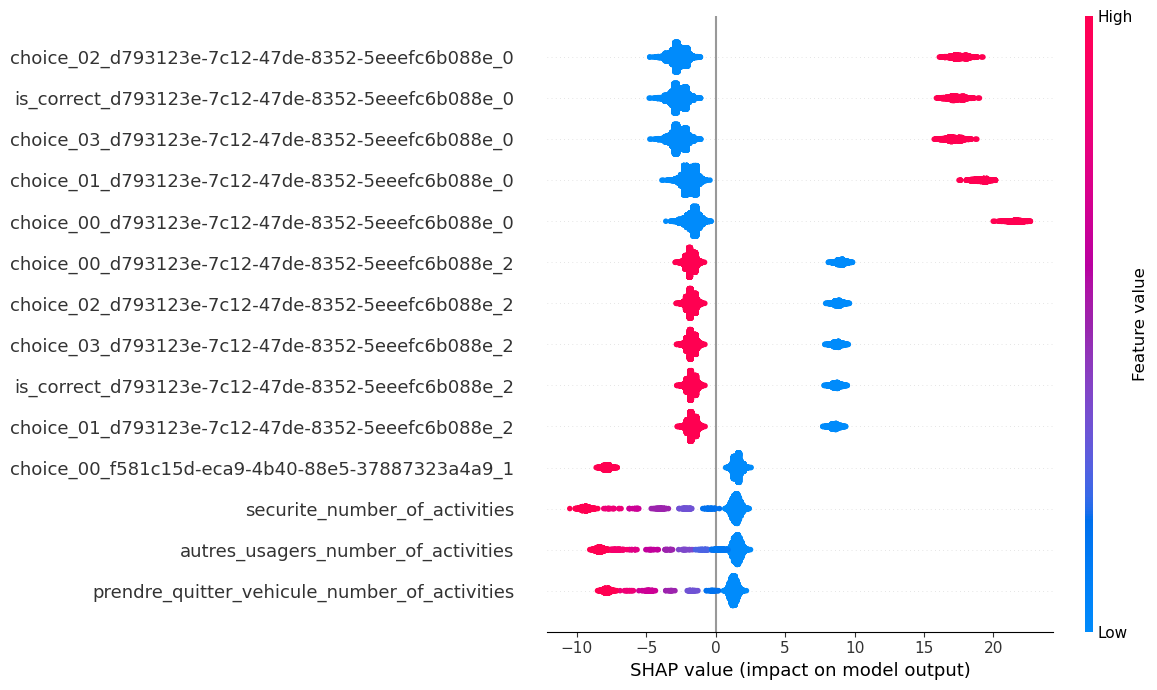

In [71]:
# Choisir la dimension latente à analyser (ex : la 5ème)
latent_dim_index = 2  # Indice 4 correspond à la 5e dimension latente

# Extraire les valeurs SHAP pour cette dimension latente
shap_val = shap_values[:, :, latent_dim_index]  # Shape : (9000, 724)

# Affichage du SHAP summary plot
shap.summary_plot(shap_val, x_test, feature_names=final_columns, max_display=14,plot_size=(12, 7))

Nous recensons ici des : 

* Variables liées aux **questions du test théorique**

  - `choice_02_d793123e-7c12-47de-8352-5eeefc6b088e_0`  
  - `is_correct_d793123e-7c12-47de-8352-5eeefc6b088e_0`  
  - `choice_03_d793123e-7c12-47de-8352-5eeefc6b088e_0`  
  - `choice_01_d793123e-7c12-47de-8352-5eeefc6b088e_0`  
  - `is_correct_87d3392f-53cc-40f3-8e4a-a857ad631821_0`  
  - `choice_03_87d3392f-53cc-40f3-8e4a-a857ad631821_0`  
  - `choice_00_87d3392f-53cc-40f3-8e4a-a857ad631821_1`  
✔ **Les réponses aux questions influencent fortement ce facteur.**  
✔ **Le choix des réponses impacte plus que leur exactitude**, indiquant une prise de décision plutôt qu’une simple performance.  

* Variables liées au **manque d'investissement dans la formation**

  - `securite_number_of_activities`  
  - `autres_usagers_number_of_activities`  
  - `prendre_quitter_vehicule_number_of_activities`   
✔ **Un faible nombre d'activités est associé à une augmentation de ce facteur.**  
✔ Cela signifie que ce facteur capte **le manque de pratique et d’engagement dans la formation**.  

* Variables liées à **l’échec ou absence d’info sur les examens**

  - `is_first_exam_success_1` (**Réussite au premier essai**)  
  - `is_first_exam_success_2` (**NA, absence d’info**)  
  - `pct_no_objective_weeks` (**Semaines sans objectif**)  
  - `pct_study_objective_not_reached` (**Objectifs non atteints**)   
✔ **L’échec au premier essai ou l’absence de données sur la réussite augmente ce facteur.**  
✔ **Le manque d’objectifs pédagogiques contribue aussi à son augmentation.**  

* **Synthèse : Ce que représente ce facteur**  
✔ **Ce facteur reflète surtout la manière dont les candidats abordent le test théorique.**  
✔ Il capte **les choix de réponse plus que leur exactitude**, suggérant une mesure du raisonnement plutôt que de la simple connaissance.  
✔ Il est aussi lié à **un faible engagement dans la formation pratique** et à **un manque d'objectifs structurés**.  
✔ **Les candidats qui réussissent du premier coup ont tendance à avoir une valeur plus faible sur ce facteur.**  
  
Nous proposons donc à cette troisième variable latente le nom : **"Comportement au test théorique et engagement limité dans la formation"**



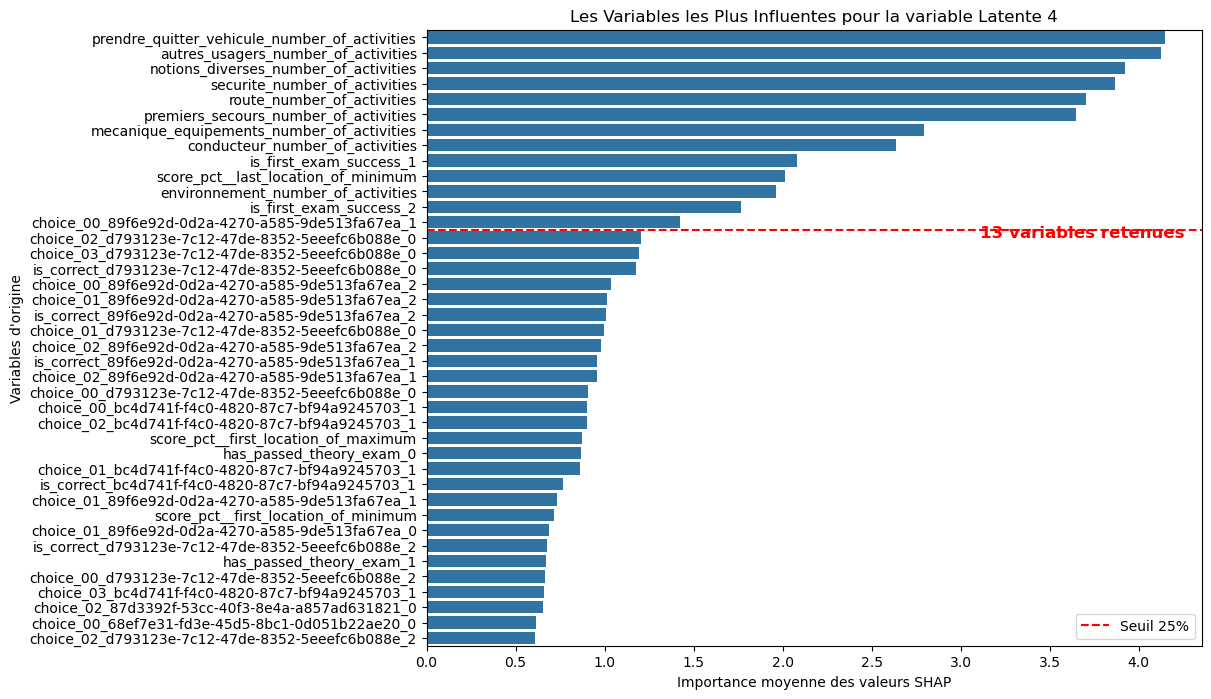

Nombre de variables nécessaires pour couvrir 25% de l'importance totale : 13


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choix de la dimension latente
i = 3  # Modifier si besoin

# Extraction des SHAP values pour cette dimension latente
shap_val = shap_values[:, :, i]  

# Création d'un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  

# Importance moyenne absolue des SHAP values (classement décroissant)
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  

# Calcul de l'importance cumulée
cumulative_importance = mean_shap_values.cumsum() / mean_shap_values.sum()

# Trouver le nombre de variables nécessaires pour atteindre 30% de l'importance cumulée
num_selected_features = (cumulative_importance <= 0.25).sum()

# Affichage du barplot avec trait horizontal pour 30%
plt.figure(figsize=(10, 8))
sns.barplot(x=mean_shap_values.head(40).values, y=mean_shap_values.head(40).index, orient='h')

# Ajout d'un trait horizontal au niveau du seuil des 30%
plt.axhline(y=num_selected_features - 0.5, color='red', linestyle='--', label="Seuil 25%")

# Annotation du nombre de variables retenues
plt.text(mean_shap_values.max() * 0.75, num_selected_features, 
         f"{num_selected_features} variables retenues", 
         color="red", fontsize=12, fontweight="bold")

# Titres et labels
plt.title(f"Les Variables les Plus Influentes pour la variable Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.legend()
plt.show()

# Affichage du nombre de variables retenues
print(f"Nombre de variables nécessaires pour couvrir 25% de l'importance totale : {num_selected_features}")


Pour cette deuxième variable latente, nous nous servirons donc aussi des 13 variables d'origines comme indiquée sur la représentation précédente pour l'explication de la variable latente à l'aide du **Beeswarm**. 

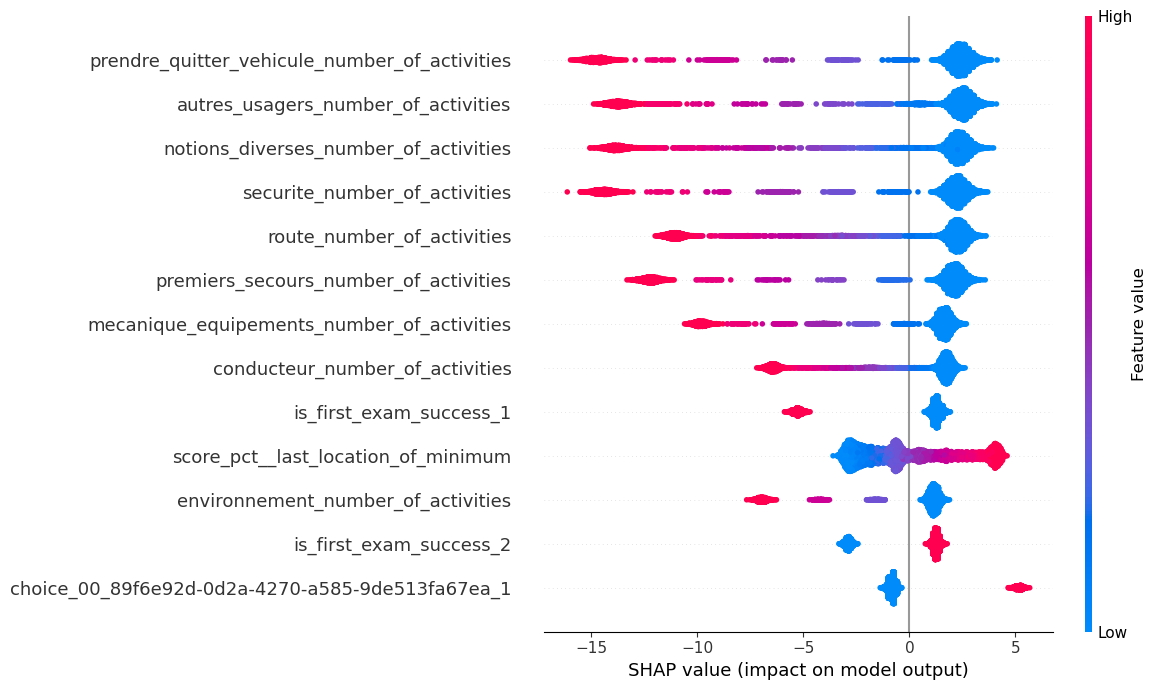

In [72]:
# Choisir la dimension latente à analyser (ex : la 5ème)
latent_dim_index = 3  

# Extraire les valeurs SHAP pour cette dimension latente
shap_val = shap_values[:, :, latent_dim_index]  # Shape : (9000, 724)

# Affichage du SHAP summary plot
shap.summary_plot(shap_val, x_test, feature_names=final_columns, max_display=13,plot_size=(12, 7))

Nous recensons ici des :  
**Variables liées au manque d'investissement dans la formation**  
  - `prendre_quitter_vehicule_number_of_activities`  
  - `autres_usagers_number_of_activities`  
  - `notions_diverses_number_of_activities`  
  - `securite_number_of_activities`  
  - `route_number_of_activities`  
  - `premiers_secours_number_of_activities`  
  - `mecanique_equipements_number_of_activities`  
  - `environnement_number_of_activities`  
  - `conducteur_number_of_activities`  
✔ **Un faible nombre d’activités dans ces catégories est fortement associé à une augmentation du facteur.**  
✔ Cela signifie que ce facteur **captive le manque d’engagement dans la formation et la faible exposition aux thématiques clés du code de la route.**  
✔ **Les candidats qui réalisent peu d’activités dans ces domaines semblent moins préparés au test théorique.**  

**Variables liées à la réussite ou à l’échec à l’examen**  
  - `is_first_exam_success_1` (**Réussite au premier essai**)  
  - `is_first_exam_success_2` (**NA, absence d’info sur la réussite**)  
  - `score_pct__last_location_of_minimum` (**Score minimal atteint en dernier lieu**)  
✔ **L’échec au premier essai ou l’absence d’information sur la réussite sont corrélés à une augmentation de ce facteur.**  
✔ **Les candidats ayant obtenu des scores faibles récemment ont aussi une valeur plus élevée sur ce facteur.**  

**Variables liées aux réponses aux questions du test théorique**  
  - `choice_00_89f6e92d-0d2a-4270-a585-9de513fa67ea_1`  
✔ **Certaines réponses aux questions du test influencent ce facteur, mais elles sont secondaires par rapport aux indicateurs de préparation.**  
✔ **Cela suggère que le facteur reflète surtout un manque de préparation plutôt qu’un comportement spécifique lors du test.**  


**Synthèse : Ce que représente ce facteur**  

✔ **Ce facteur capte avant tout un faible investissement dans la formation et une préparation insuffisante.**  
✔ Il est fortement lié au **manque de pratique**, à **l’absence d’activités pédagogiques**, et à **l’échec au premier essai**.  
✔ **Les candidats qui réussissent mieux au test théorique et s’investissent davantage dans leur formation ont une valeur plus faible sur ce facteur.**  


On propose donc pour cette quatrième dimension le nom **"Faible engagement et préparation insuffisante au test théorique"**  


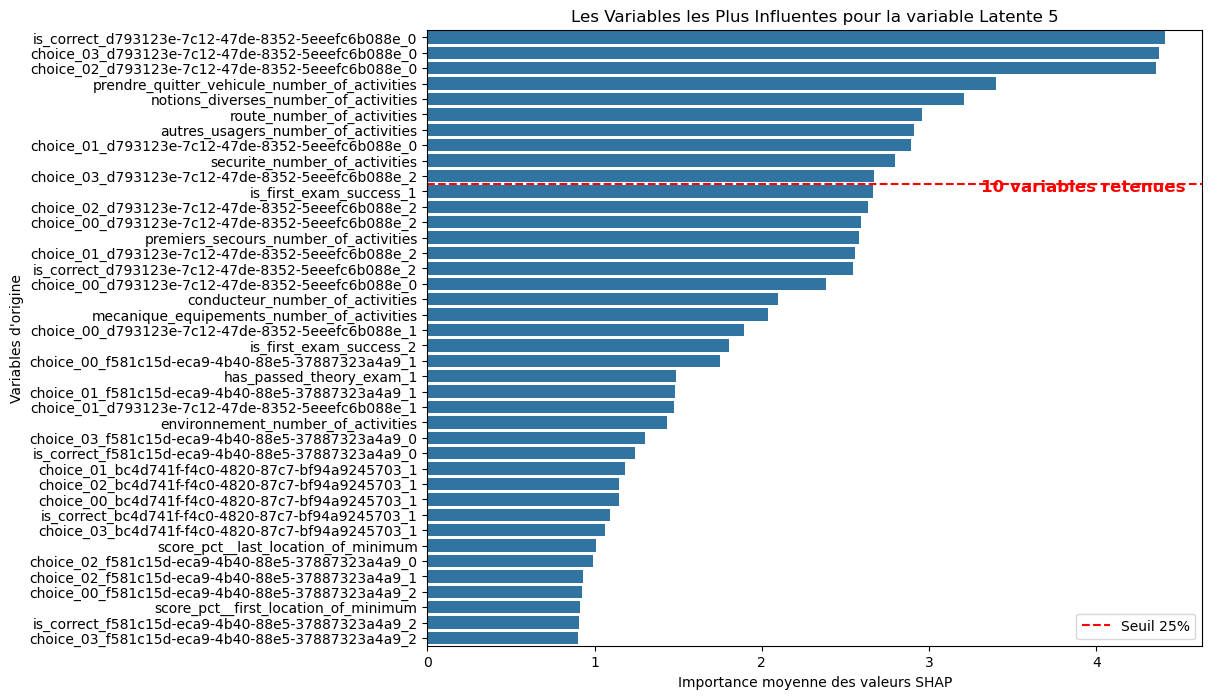

Nombre de variables nécessaires pour couvrir 25% de l'importance totale : 10


In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choix de la dimension latente
i = 4  # Modifier si besoin

# Extraction des SHAP values pour cette dimension latente
shap_val = shap_values[:, :, i]  

# Création d'un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  

# Importance moyenne absolue des SHAP values (classement décroissant)
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  

# Calcul de l'importance cumulée
cumulative_importance = mean_shap_values.cumsum() / mean_shap_values.sum()

# Trouver le nombre de variables nécessaires pour atteindre 30% de l'importance cumulée
num_selected_features = (cumulative_importance <= 0.25).sum()

# Affichage du barplot avec trait horizontal pour 30%
plt.figure(figsize=(10, 8))
sns.barplot(x=mean_shap_values.head(40).values, y=mean_shap_values.head(40).index, orient='h')

# Ajout d'un trait horizontal au niveau du seuil des 30%
plt.axhline(y=num_selected_features - 0.5, color='red', linestyle='--', label="Seuil 25%")

# Annotation du nombre de variables retenues
plt.text(mean_shap_values.max() * 0.75, num_selected_features, 
         f"{num_selected_features} variables retenues", 
         color="red", fontsize=12, fontweight="bold")

# Titres et labels
plt.title(f"Les Variables les Plus Influentes pour la variable Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.legend()
plt.show()

# Affichage du nombre de variables retenues
print(f"Nombre de variables nécessaires pour couvrir 25% de l'importance totale : {num_selected_features}")


Pour cette dernière variable latente, nous nous servirons donc aussi des 10 variables d'origines comme indiquée sur la représentation précédente pour l'explication de la variable latente à l'aide du **Beeswarm**. 

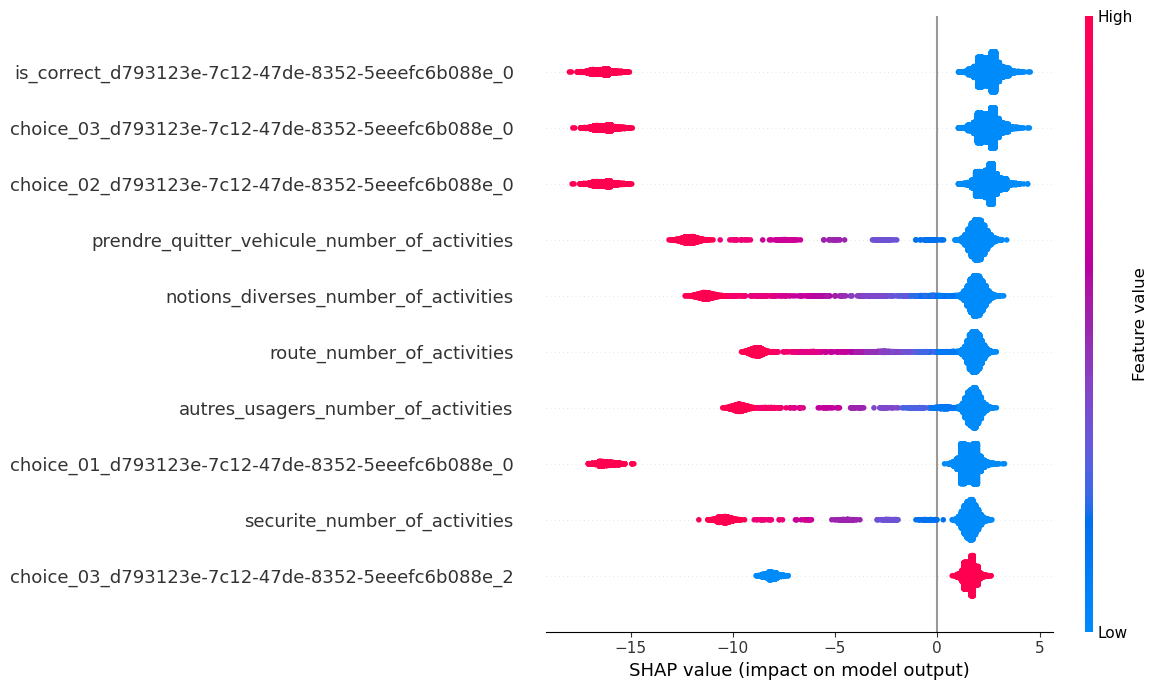

In [74]:
# Choisir la dimension latente à analyser (ex : la 5ème)
latent_dim_index = 4  

# Extraire les valeurs SHAP pour cette dimension latente
shap_val = shap_values[:, :, latent_dim_index]  # Shape : (9000, 724)

# Affichage du SHAP summary plot
shap.summary_plot(shap_val, x_test, feature_names=final_columns, max_display=10,plot_size=(12, 7))

Nous recensons ici des :  

**Variables liées aux questions du test théorique**  
  - `is_correct_d793123e-7c12-47de-8352-5eeefc6b088e_0`  
  - `choice_03_d793123e-7c12-47de-8352-5eeefc6b088e_0`  
  - `choice_02_d793123e-7c12-47de-8352-5eeefc6b088e_0`  
  - `choice_01_d793123e-7c12-47de-8352-5eeefc6b088e_0`  
  - `choice_03_d793123e-7c12-47de-8352-5eeefc6b088e_2`  
✔ **Les choix de réponse jouent un rôle, mais sont moins dominants que dans la troisième dimension.**  
✔ **L’exactitude des réponses est prise en compte, mais avec un effet plus secondaire.**  

**Variables liées au manque d'investissement dans la formation pratique (fortement représentées)**  
  - `prendre_quitter_vehicule_number_of_activities`  
  - `notions_diverses_number_of_activities`  
  - `route_number_of_activities`  
  - `autres_usagers_number_of_activities`  
  - `securite_number_of_activities`  
✔ **Cette dimension est particulièrement influencée par un faible nombre d'activités pratiques.**  
✔ **L’absence d’entraînement concret semble impacter la manière dont les candidats abordent le test.**  

**Synthèse : Ce que représente ce facteur**  
✔ **Ce facteur reflète avant tout un manque prononcé de pratique et de préparation concrète.**  
✔ **Il traduit aussi une influence sur le raisonnement au test, potentiellement liée à une faible exposition aux situations pratiques.**  
✔ Contrairement à la troisième dimension, où intervient faiblement la manque de pratique, **ici c’est la pratique elle-même qui semble déterminante.**  

Nous proposons donc pour cette dernière dimension le nom **"Manque prononcé de pratique et influence sur le raisonnement au test"**  


## Conception de l'autoencodeur sur les variables continues

    encoding_dim      loss
0              1  0.012035
1              2  0.009823
2              3  0.007376
3              4  0.006276
4              5  0.005308
5              6  0.004686
6              7  0.004260
7              8  0.003889
8              9  0.003481
9             10  0.003224
10            11  0.002994
11            12  0.002785
12            13  0.002567
13            14  0.002426
14            15  0.002196
15            16  0.002057
16            17  0.001917
17            18  0.001768
18            19  0.001707
19            20  0.001650


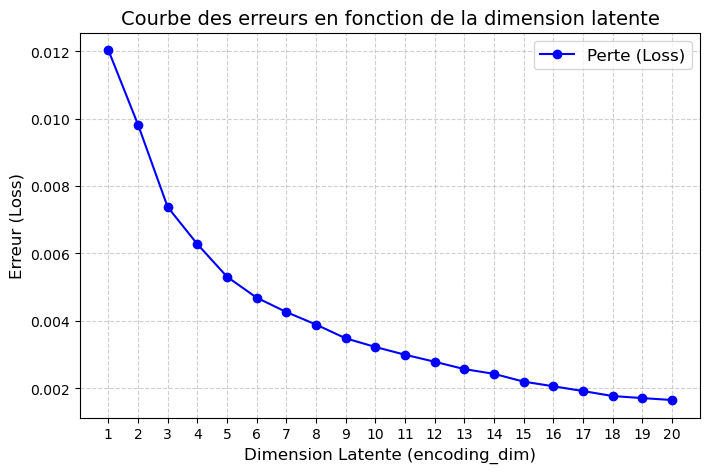

In [ ]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer uniquement les colonnes numériques 
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns


# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(numerical_cols)

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
input_dim = x_train.shape[1]

# === 3. Entraînement des autoencodeurs pour différentes dimensions latentes ===
results = []

for encoding_dim in range(1, 21):  # Tester des dimensions latentes de 1 à 20
    # Initialisation déterministe des poids
    initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

    # Construction de l'autoencodeur
    input_img = Input(shape=(input_dim,))
    # Encodeur
    Hidden1 = Dense(150, activation='linear', kernel_initializer=initializer)(input_img)
    #Hidden2 = Dense(100, activation='linear', kernel_initializer=initializer)(Hidden1)
    #Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
    encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

    # Décodeur
    Hidden_output1 = Dense(150, activation='sigmoid', kernel_initializer=initializer)(encoded)
    #Hidden_output2 = Dense(100, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)
    #Hidden_output3 = Dense(350, activation='sigmoid', kernel_initializer=initializer)(Hidden_output2)
    decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche


    # Créer le modèle
    autoencoder = Model(input_img, decoded)

    # Compiler le modèle
    autoencoder.compile(optimizer='adam', loss='mse')

    # Entraîner le modèle
    history = autoencoder.fit(
        x_train, x_train,
        epochs=50,
        batch_size=256,
        shuffle=True,
        validation_data=(x_test, x_test),
        verbose=0
    )

    # Récupérer la perte de validation à la dernière époque
    final_loss = history.history['val_loss'][-1]

    # Ajouter la dimension et la perte au tableau des résultats
    results.append({'encoding_dim': encoding_dim, 'loss': final_loss})

# === 4. Visualisation des résultats ===
df_results = pd.DataFrame(results)
print(df_results)

plt.figure(figsize=(8, 5))
plt.plot(df_results['encoding_dim'], df_results['loss'], marker='o', linestyle='-', color='b', label='Perte (Loss)')
plt.xlabel('Dimension Latente (encoding_dim)', fontsize=12)
plt.ylabel('Erreur (Loss)', fontsize=12)
plt.title('Courbe des erreurs en fonction de la dimension latente', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(df_results['encoding_dim'])
plt.legend(fontsize=12)
plt.show()


Ainsi lorsque la dimension de l'espace latent varie entre 1 et 20, l'erreur de reconstruction varie entre 0.012 et 0.0016

Dans le cas de l'ACP, elle vaut lorsque 5 axes factorielles sont retenus  environ 0.54.

La FAMD quant à elle ne peut s'appliquer que sur un ensemble de données mixtes. On n'a donc pas pu la restreindre aux variables continues avant le calcul de l'erreur de reconstruction. L'erreur de reconstruction retrouvée est d'environ 16, ce qui est relativement élevé par rapport à celles retrouvé pour les autres méthodes

In [ ]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression

base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1)

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

def mutual_information_matrix(X_orig, X_latent):
    """
    Calcule la matrice d'information mutuelle entre les variables d'origine et les variables latentes.
    """
    n_orig = X_orig.shape[1]  # Nombre de variables d'origine
    n_latent = X_latent.shape[1]  # Nombre de variables latentes

    mi_matrix = np.zeros((n_orig, n_latent))

    for i in range(n_orig):
        for j in range(n_latent):
            mi_matrix[i, j] = mutual_info_score(X_orig[:, i], X_latent[:, j])

    return mi_matrix

encoded_imgs = encoder_model.predict(final_data)

# Calcul de la matrice d'information mutuelle
mi_matrix = mutual_information_matrix(final_data, encoded_imgs)


## Passage à la base Assu

In [29]:
!pip install pyarrow

In [2]:
# import pandas as pd
# base_assu=pd.read_parquet("D:\\2AD ENSAE\\Projet de statistique appliquée\\Dossier travail\\base_assu.parquet",engine='pyarrow')

In [5]:
import pandas as pd
import pyarrow.parquet as pq

#A priori avec le code suivant, cela marche : 



# Chemin du fichier
chemin_fichier = "D:\\2AD ENSAE\\Projet de statistique appliquée\\Dossier travail\\base_assu.parquet"

# Lire les métadonnées du fichier (sans charger les données)
parquet_file = pq.ParquetFile(chemin_fichier)

# Obtenir la liste des colonnes SANS charger le fichier
all_columns = parquet_file.schema.names

print(all_columns)
 
# Exclure la colonne problématique
columns_to_read = [col for col in all_columns if col != "first_theory_activity_date" and col != "var_Assurance19"]
 
# Lire uniquement les colonnes sélectionnées
base_assu = pd.read_parquet(chemin_fichier, columns=columns_to_read, engine="fastparquet")

print("Fichier importé avec succès 9")

display(base_assu)

['unique_learner_id', 'days_between_signup_and_first_activity', 'days_between_order_and_first_activity', 'first_theory_activity_date', 'days_between_first_and_last_activities', 'chapter_before_success_count', 'serie_before_success_count', 'quiz_before_success_count', 'theory_activities_total', 'weekly_study_objective', 'is_first_exam_success', 'days_between_booking_and_exam', 'nb_mistakes_first_exam', 'score_at_registration', 'score_before_exam', 'days_between_first_activity_and_exam', 'days_between_order_and_exam', 'avg_self_assessment', 'avg_self_assessment_gap', 'percentage_activities_2_3_4h_week', 'percentage_activities_5_6_7h_week', 'percentage_activities_23_0_1h_week', 'percentage_activities_2_3_4h_weekend', 'percentage_activities_5_6_7h_weekend', 'percentage_activities_23_0_1h_weekend', 'percentage_activities_8h_week', 'percentage_activities_8h_weekend', 'percentage_activities_9h_week', 'percentage_activities_9h_weekend', 'percentage_activities_10h_week', 'percentage_activities_

unique_learner_id  days_between_signup_and_first_activity  \
0      -9209947526891003402                                     254   
1       5932580794384582589                                       8   
2       4336757673841606054                                     287   
3       1964860462838851923                                       0   
4      -1955538004573216258                                     175   
...                     ...                                     ...   
40152  -6381987474553350311                                     325   
40153  -5410493136313413497                                    1053   
40154   3384927917007667788                                       0   
40155    371936028404622808                                       0   
40156  -5675536495244026721                                     694   

       days_between_order_and_first_activity  \
0                                        254   
1                                          7   
2                                         48   
3                                       -229   
4                                        176   
...                                      ...   
40152                                    326   
40153                                   1054   
40154                                      0   
40155                                    -15   
40156                                    695   

       days_between_first_and_last_activities  chapter_before_success_count  \
0                                         102                             0   
1                                         910                             0   
2                                         342                             0   
3                                         313                             0   
4                                         636                             0   
...                                       ...                           ...   
40152                                     827                             0   
40153                                      56                             0   
40154                                     139                             0   
40155                                     271                             0   
40156                                     230                             0   

       serie_before_success_count  quiz_before_success_count  \
0                               0                          0   
1                               0                          0   
2                              92                          0   
3                             228                          0   
4                              88                          0   
...                           ...                        ...   
40152                           0                          0   
40153                          58                         34   
40154                           0                          0   
40155                          38                         53   
40156                           0                          0   

       theory_activities_total  weekly_study_objective  is_first_exam_success  \
0                           57                     120                  False   
1                           84                      90                   <NA>   
2                          247                     240                   True   
3                          228                     240                   True   
4                           93                     240                   True   
...                        ...                     ...                    ...   
40152                       52                      90                   <NA>   
40153                       92                     240                   True   
40154                       62                     240                   <NA>   
40155                       91                     1

In [1]:
#base_assu.to_parquet("D:\\2AD ENSAE\\Projet de statistique appliquée\\Dossier travail\\base_Assu.parquet")

In [1]:
import pandas as pd
base_Assu=pd.read_parquet("D:\\2AD ENSAE\\Projet de statistique appliquée\\Dossier travail\\base_Assu.parquet")

In [36]:
colvar_Assu=base_Assu.columns
colvar_Edu=base_AE.columns
communs = list(set(colvar_Edu) & set(colvar_Assu))

In [23]:
if base_Assu["unique_learner_id"].isin(base_Edu["unique_learner_id"]).any():
    n=base_Assu["unique_learner_id"].isin(base_Edu["unique_learner_id"]).sum()
    print("Il y a des identifiants communs entre les deux bases. Exatement : ",n)

Il y a des identifiants communs entre les deux bases. Exatement :  3641


In [25]:
3641/200000

0.018205

In [26]:
base_Assu0=base_Assu.drop(columns=communs)
base_Assu0

var_Assurance0  var_Assurance1  var_Assurance2  var_Assurance3  \
0                True            1.00           False              13   
1                True            1.00            True              91   
2                True            0.90           False            <NA>   
3                True            0.90            True              96   
4                True            1.00           False               5   
...               ...             ...             ...             ...   
40152            True            1.00            True              22   
40153            True            0.95            True              44   
40154            True            0.85            True              32   
40155            True            1.00           False              62   
40156            True            1.00           False              50   

       var_Assurance4  var_Assurance5  var_Assurance6  var_Assurance7  \
0            0.654346               0               0               0   
1            0.752909               0               0               0   
2            2.609172               0               0               0   
3            1.998631               0               0               0   
4            0.539357               0               0               0   
...               ...             ...             ...             ...   
40152        2.001369               0               0               0   
40153        0.999316               0               0               0   
40154        3.000684               0               0               0   
40155        3.000684               0               0               0   
40156        2.789870               0               0               0   

       var_Assurance8  var_Assurance9  var_Assurance10  var_Assurance11  \
0                   0               0                0                0   
1                   0               0                0                0   
2                   0               0                0                0   
3                   0               0                0                0   
4                   0               1                0                1   
...               ...             ...              ...              ...   
40152               0               0                0                0   
40153               0               0                0                0   
40154               0               0                0                0   
40155               0               0                0                0   
40156               0               0                0                0   

       var_Assurance12  var_Assurance13  var_Assurance14  var_Assurance15  \
0                    0                0                0                0   
1                    0                0                0                0   
2                    0                0                0                0   
3                    0                0                0                0   
4                    0                0                0                0   
...                ...              ...              ...              ...   
40152                0                0                0                0   
40153                0                0                0                0   
40154                0                0                0                0   
40155                0                0                0                0   
40156                0                0                0                0   

       var_Assurance16  var_Assurance17  var_Assurance18  
0                    0                0                0  
1                    0                0                0  
2                    0                0                0  
3                    0                0                0  
4                    0                0                0  
...                ...              ...              ...  
40152         

In [27]:
base_Assu0.describe()

var_Assurance1  var_Assurance3  var_Assurance4  var_Assurance5  \
count    40157.000000         35622.0    40157.000000         40157.0   
mean         0.936362       51.492084        1.676935        0.006699   
std          0.154072       29.878804        1.019419        0.083979   
min          0.500000             0.0        0.002738             0.0   
25%          0.900000            25.0        0.752909             0.0   
50%          0.950000            53.0        1.533196             0.0   
75%          1.000000            78.0        2.751540             0.0   
max          3.500000           100.0       22.997947             2.0   

       var_Assurance6  var_Assurance7  var_Assurance8  var_Assurance9  \
count         40157.0         40157.0         40157.0         40157.0   
mean         0.135966         0.05598        0.001718        0.004856   
std          0.411255        0.256218        0.042014         0.07198   
min               0.0             0.0             0.0             0.0   
25%               0.0             0.0             0.0             0.0   
50%               0.0             0.0             0.0             0.0   
75%               0.0             0.0             0.0             0.0   
max               5.0             4.0             2.0             2.0   

       var_Assurance10  var_Assurance11  var_Assurance12  var_Assurance13  \
count          40157.0          40157.0          40157.0          40157.0   
mean          0.018228         0.223448         0.004084         0.073213   
std           0.144861         0.557484         0.064552         0.289297   
min                0.0              0.0              0.0              0.0   
25%                0.0              0.0              0.0              0.0   
50%                0.0              0.0              0.0              0.0   
75%                0.0              0.0              0.0              0.0   
max                3.0              7.0              2.0              5.0   

       var_Assurance14  var_Assurance15  var_Assurance16  var_Assurance17  \
count          40157.0          40157.0          40157.0          40157.0   
mean               0.0              0.0              0.0              0.0   
std                0.0              0.0              0.0              0.0   
min                0.0              0.0              0.0              0.0   
25%                0.0              0.0              0.0              0.0   
50%                0.0              0.0              0.0              0.0   
75%                0.0              0.0              0.0              0.0   
max                0.0              0.0              0.0              0.0   

       var_Assurance18  
count          40157.0  
mean          0.077297  
std           0.298253  
min                0.0  
25%                0.0  
50%                0.0  
75%                0.0  
max                5.0

In [37]:
catcol=base_Edu.select_dtypes('category').columns
base_Assu1=base_Assu[communs]
base_Assu[catcol]

KeyError: "['has_passed_theory_exam'] not in index"

In [38]:
len(communs)

335

In [39]:
len(base_AE.columns)

371

In [40]:
c=base_AE.columns.drop(communs)

In [43]:
print(len(c))
c

36


Index(['has_passed_theory_exam', 'score_pct__mean_abs_change',
       'score_pct__mean_change', 'score_pct__mean_second_derivative_central',
       'score_pct__standard_deviation', 'score_pct__variation_coefficient',
       'score_pct__skewness', 'score_pct__kurtosis',
       'score_pct__first_location_of_maximum',
       'score_pct__last_location_of_minimum',
       'score_pct__first_location_of_minimum', 'score_pct__minimum',
       'score_pct__c3__lag_1', 'score_pct__c3__lag_2', 'score_pct__c3__lag_3',
       'score_pct__quantile__q_0_1', 'score_pct__quantile__q_0_2',
       'score_pct__quantile__q_0_3', 'score_pct__quantile__q_0_4',
       'score_pct__linear_trend__attr_intercept',
       'score_pct__linear_trend__attr_slope',
       'nb_weeks_weekly_study_objective_reached',
       'nb_weeks_weekly_study_objective_reached_99pct',
       'nb_weeks_weekly_study_objective_reached_95pct',
       'nb_weeks_weekly_study_objective_reached_90pct',
       'nb_weeks_weekly_study_objective_r

In [43]:
base_Assu0.dtypes

var_Assurance0     boolean
var_Assurance1     float64
var_Assurance2     boolean
var_Assurance3       Int64
var_Assurance4     float64
var_Assurance5       Int64
var_Assurance6       Int64
var_Assurance7       Int64
var_Assurance8       Int64
var_Assurance9       Int64
var_Assurance10      Int64
var_Assurance11      Int64
var_Assurance12      Int64
var_Assurance13      Int64
var_Assurance14      Int64
var_Assurance15      Int64
var_Assurance16      Int64
var_Assurance17      Int64
var_Assurance18      Int64
dtype: object

In [42]:
print(base_Assu0.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(base_Assu0.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(base_Assu0.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(base_Assu0.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

1  variables de type int ont des valeurs manquantes
0  variables de type float ont des valeurs manquantes
0  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


In [47]:
miss_quant=base_Assu0.select_dtypes(include=["int","float"]).isnull().sum()/len(base_Assu0)
miss_quant

var_Assurance1     0.000000
var_Assurance3     0.112932
var_Assurance4     0.000000
var_Assurance5     0.000000
var_Assurance6     0.000000
var_Assurance7     0.000000
var_Assurance8     0.000000
var_Assurance9     0.000000
var_Assurance10    0.000000
var_Assurance11    0.000000
var_Assurance12    0.000000
var_Assurance13    0.000000
var_Assurance14    0.000000
var_Assurance15    0.000000
var_Assurance16    0.000000
var_Assurance17    0.000000
var_Assurance18    0.000000
dtype: float64

In [94]:
C1=base_Assu.iloc[:,0]
C1

0        -9209947526891003402
1         5932580794384582589
2         4336757673841606054
3         1964860462838851923
4        -1955538004573216258
                 ...         
40152    -6381987474553350311
40153    -5410493136313413497
40154     3384927917007667788
40155      371936028404622808
40156    -5675536495244026721
Name: unique_learner_id, Length: 40157, dtype: Int64

In [92]:
C2=base_Edu.iloc[:,0]
C2

0          3838161406066513919
1          5829430568065349352
2          7677180318050051984
3         -5150597998144597550
4           969323468959211246
                  ...         
199995     1306435320134834461
199996     5732789662758255879
199997     3325713948509922176
199998     7446387329160512320
199999     -426531306216685800
Name: unique_learner_id, Length: 200000, dtype: Int64

In [103]:
base_Edu.loc[base_Edu["unique_learner_id"]==C1]

ValueError: Can only compare identically-labeled Series objects

In [71]:
com_cell

[]

In [67]:
len(C)

199879

In [18]:
import pickle

# Sauvegarde des valeurs SHAP
with open("shap_values.pkl", "wb") as f:
    pickle.dump(shap_values, f)

In [ ]:
import shap
import numpy as np

shap.summary_plot()

# === 5. Affichage du SHAP summary plot ===
# shap_values est une liste contenant les SHAP values pour chaque dimension latente
for i, sv in enumerate(shap_values):
    print(f"Summary plot pour la dimension latente {i+1}")
    shap.summary_plot(sv, x_test, feature_names=final_columns,max_display=15)


Summary plot pour la dimension latente 1


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

SHAP values shape: (9000, 724)
Feature matrix shape: (9000, 724)


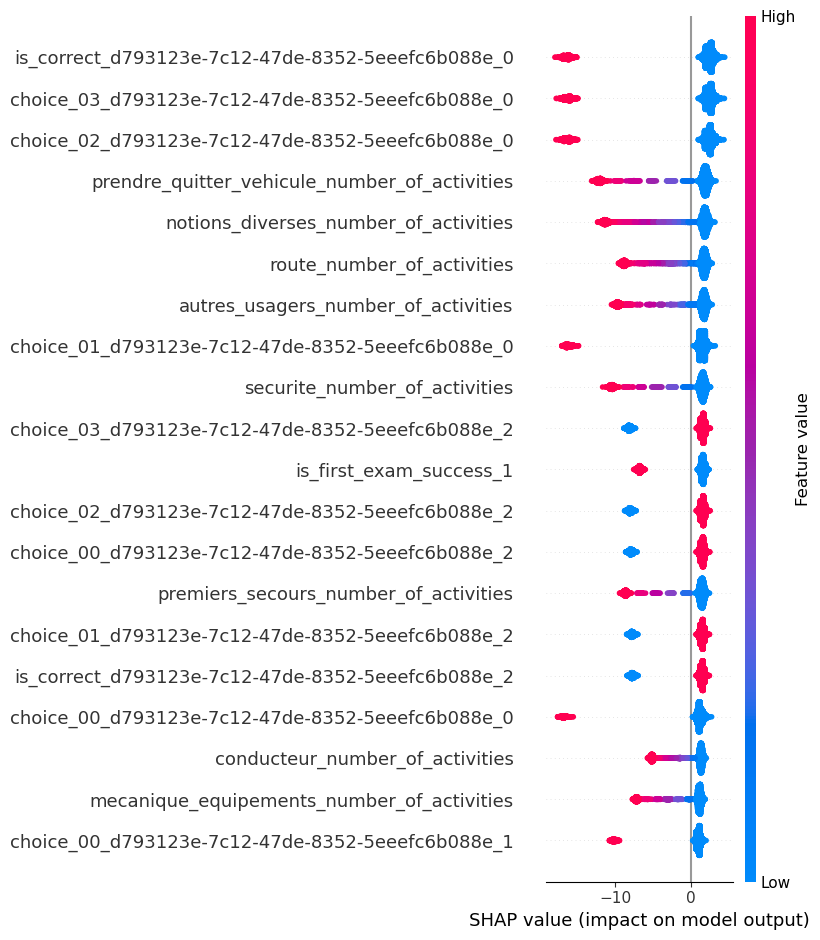

In [25]:
import shap
import numpy as np

# Choisir la dimension latente à analyser (ex : la 5ème)
latent_dim_index = 4  # Indice 4 correspond à la 5e dimension latente

# Extraire les valeurs SHAP pour cette dimension latente
shap_val = shap_values[:, :, latent_dim_index]  # Shape : (9000, 724)

# Vérifier que les dimensions correspondent bien
print(f"SHAP values shape: {shap_val.shape}")
print(f"Feature matrix shape: {x_test.shape}")

# Affichage du SHAP summary plot
shap.summary_plot(shap_val, x_test, feature_names=final_columns, max_display=20)


🔹 Summary plot pour la dimension latente 1



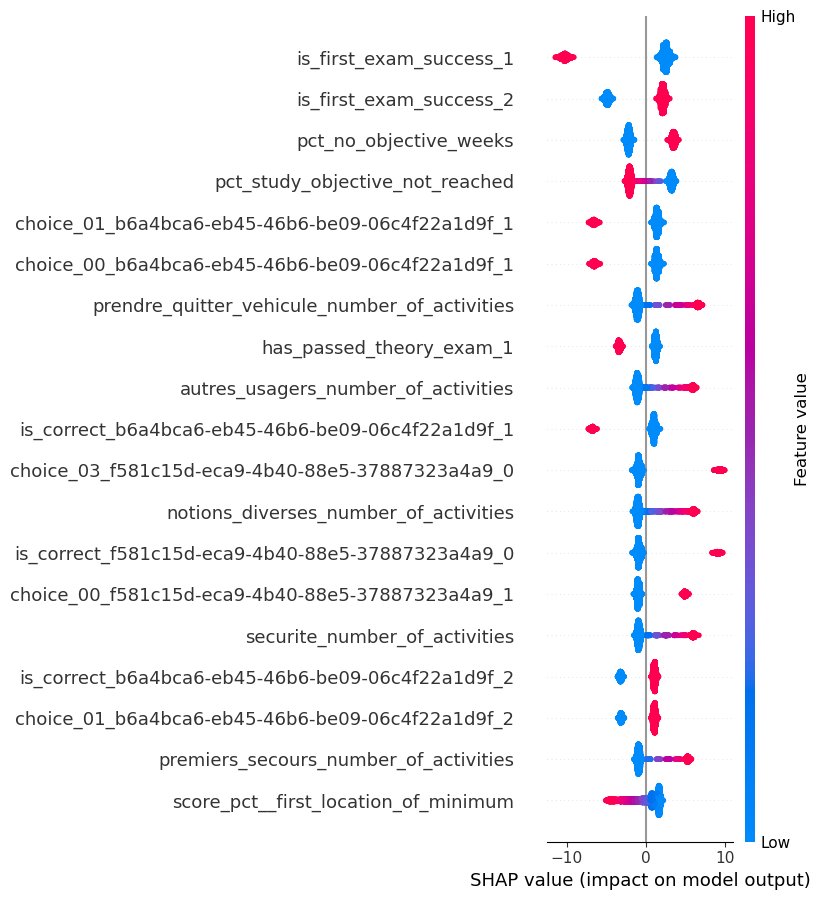

🔹 Summary plot pour la dimension latente 2



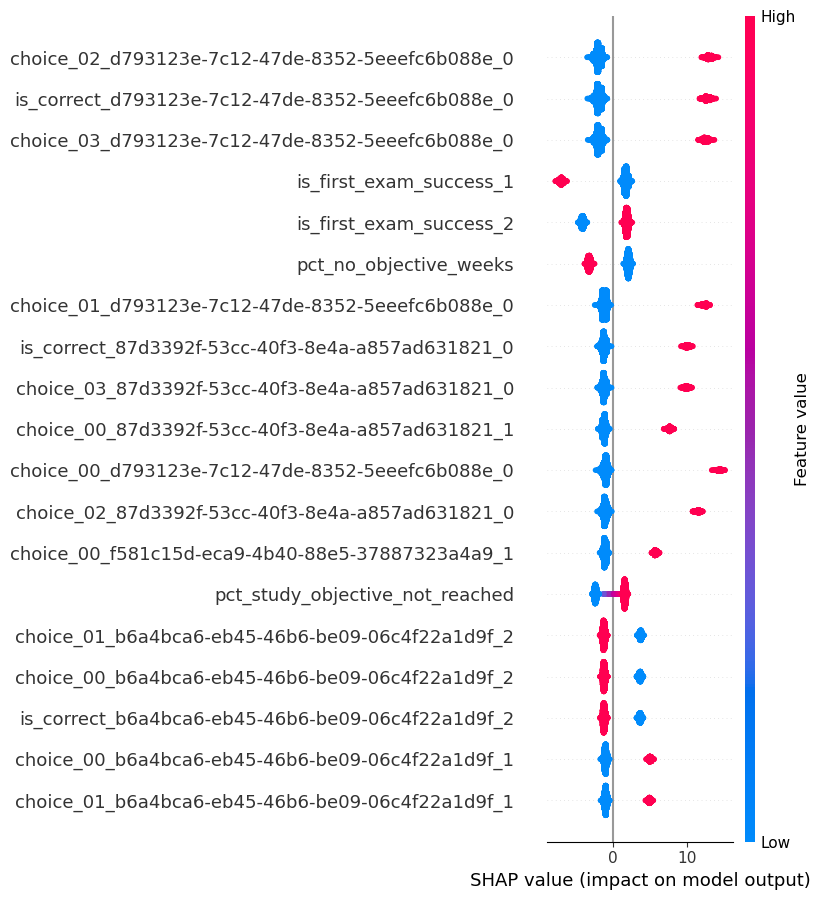

🔹 Summary plot pour la dimension latente 3



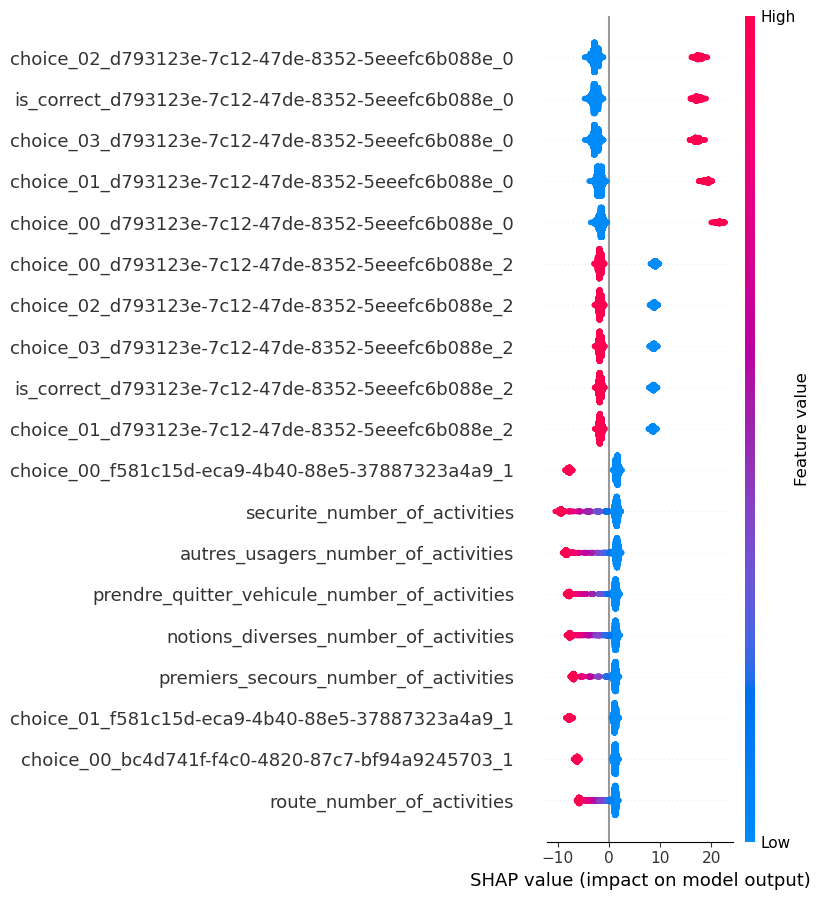

🔹 Summary plot pour la dimension latente 4



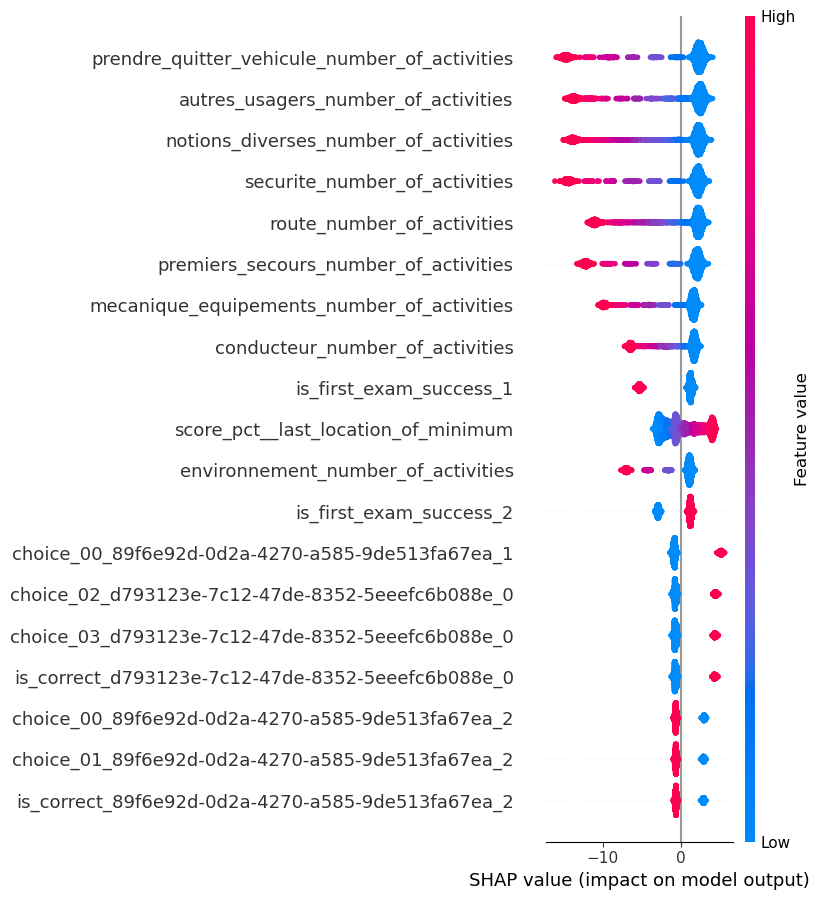

🔹 Summary plot pour la dimension latente 5



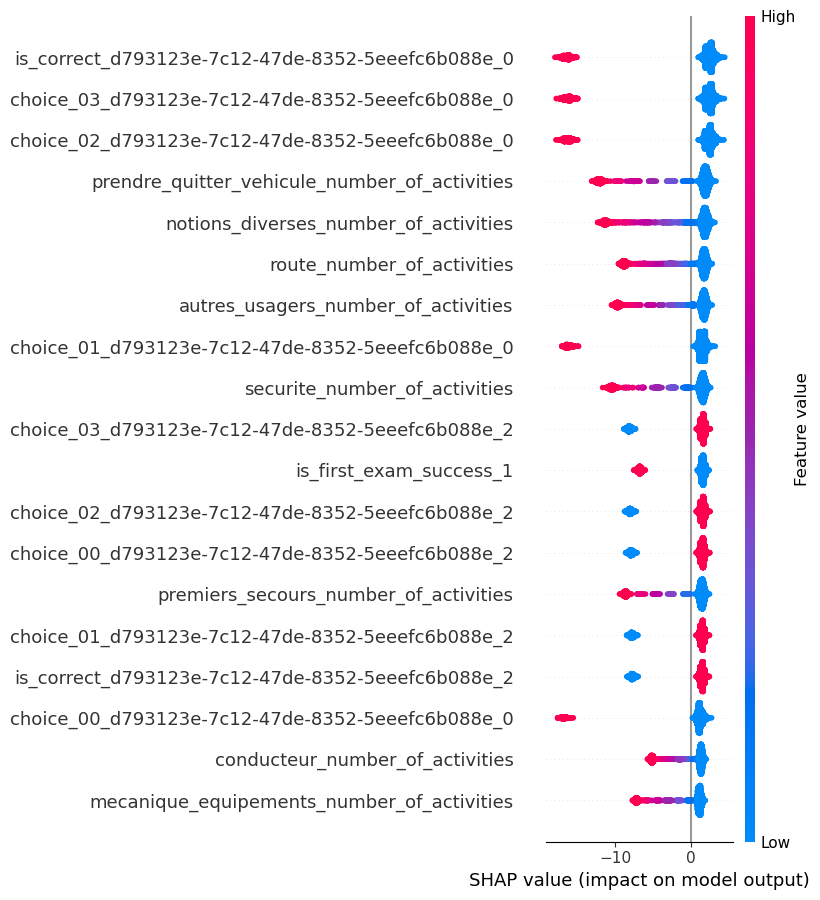

In [24]:
import shap
import numpy as np

# Nombre de dimensions latentes
num_latent_dims = shap_values.shape[2]  # Ex : 5 si ton autoencodeur encode en 5 dimensions

# Boucle sur chaque dimension latente
for i in range(num_latent_dims):
    print(f"🔹 Summary plot pour la dimension latente {i+1}\n")

    # Extraire les valeurs SHAP pour la i-ème dimension latente
    shap_val = shap_values[:, :, i]  # Shape : (9000, 724)

    # Affichage du summary plot pour cette dimension
    shap.summary_plot(shap_val, x_test, feature_names=final_columns, max_display=19)
